In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pylab as pylab
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


pylab.rcParams['figure.figsize'] = 5, 5
plt.rc("font", size=15)


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

In this notebook we are going to learn what a **decision tree** is, how it does classification and what the **hyperparameters** used to define it actually do and stand for.

Then we are going to superficially describe how decision trees are basic bricks of more powerful algorithms called **ensemble algorithms**. You will see that these algorithm can be quite diverse. Since they are quite useful and commonly used I will spend some time showing how different they actually are from one another and what that means. 

# Decision tree based classification

## Table Of Content:

* [Decision Tree](#Decision-Tree)


* [Random Forest](#Random-Forest)


* [Ada Boost](#Ada-Boost)


* [Boosted Gradient](#Boosted-Gradient)


* [Exercise](#exo)

In [3]:
# Multiclassification dataset

iris = load_iris()

df_iris = pd.concat([pd.DataFrame(iris['data'],columns=iris['feature_names']),\
                       pd.DataFrame(iris['target'],columns=['species'])],axis=1)


(X_iris, y_iris) = load_iris(return_X_y = True)



#Classification dataset

cancer = load_breast_cancer()
df_cancer = pd.concat([pd.DataFrame(cancer['data'],columns=cancer['feature_names']),\
                       pd.DataFrame(cancer['target'],columns=['malignant'])],axis=1)

(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)


In [4]:

X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(X_cancer, y_cancer,
                                                   random_state=7, stratify=y_cancer)

X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(X_iris, y_iris,
                                                   random_state=1, stratify=y_iris)

# Decision tree <a class="anchor" id="Decision-Tree"></a>

In [170]:
#only for graphical representation of the trees : you don't need it for analysis.
#you will need to pip install pydotplus the first time so just remove the # sign
#!pip install pydotplus
#You will need graphviz lib also. Download it here : https://graphviz.gitlab.io/download/
#You will need to add it to your python path
import os
os.environ["PATH"] += os.pathsep + 'C:/graphviz-2.38/release/bin/'#path where you installed it

**A simple decision tree reduces your problem into a hierarchichal sequence of questions on your features that can be answered by yes or no and that subdivides the data into 2 subgroups on which a new question is asked, and so on and so on.**

Ok, but a huge number of trees can actually be built just by considering the different orders of questions asked. How does the algorithm deals with this?

Quite simply actually. **It tests all the features and chooses the most discriminative (in terms of your labels) : the feature where a yes or no question divides the data into 2 subsets which minimizes an impurity measure.** 

**The impurity is related to how much your feature splitting is still having mixed classes**. Note that impurity then goes through a function to give a score: either it is a simple Shannon entropy or it is a Gini entropy.

Imagine you have a dataset with feature color (red or blue) and feature shape (square or circle), and 2 classes (1,2):

If answering `True` to "feature color is red" gives you a subgroup of 10 class 1, and 1 class 2 and, `False` gives you 2 class 1, and 11 class 2 then it is a better classifier than:

"feature shape is square" that gives you a subgroup of 5 class 1, and 7 class 2 on one hand, and 7 class 1 and 5 class 2 on the other hand.

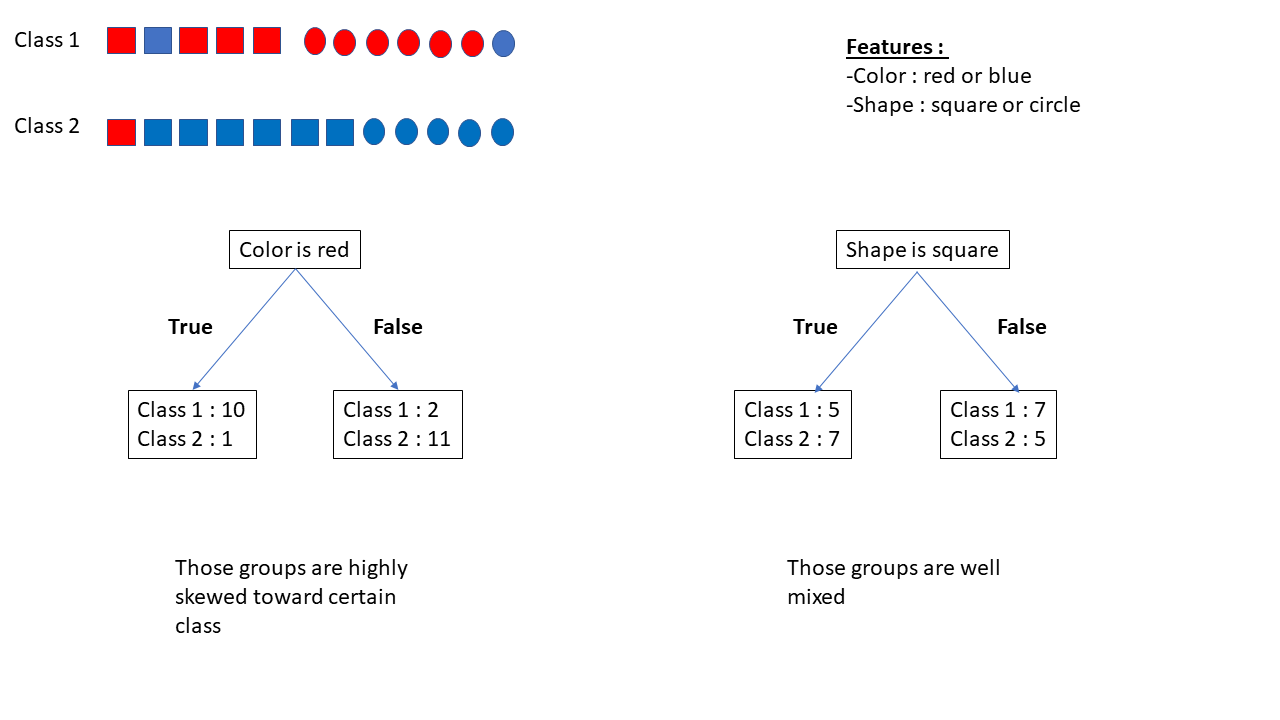

In [6]:
from IPython.display import Image
Image('../images/Tree.png')

**The points are better separated in terms of their classes by answering True or False for feature color than for feature shape.** Some of you could already see that entropy calculation could be a good way to summarize all that text above, hence my little aparte about impurity before.

**This is something "easy" to visualize if your features are categorical like 'yellow' but if they are numeric features like weights, how do you transform that to a yes/no questions? By choosing a threshold...** But how do you choose the threshold? Again choose threshold which minimize impurity. When you have a threshold for each feature then you can compare their impurities. You will have to compute this threshold at each step of your tree since at each step you are considering different subdatasets.


Before going further, just a little bit of vocabulary: 
* **Trees** are made of **nodes** (where the question is asked and where the splitting occurs). 
* A **branch** is the outcome of a splitting. 
* A **leaf** is the last node on a branch (no more splitting).

### Toy data : exploring hyperparameters


Let explore some hyperparameters of this method that, you will see in those examples, act like a regularization:
- **Max Tree depth**: the maximum number of consecutive questions to ask
- **Min Splitting of nodes**: the minimum number of point that should be considered to make a new rule, outside of the leaves
- **Min Splitting of leaves**: the minimum number of point that should be considered to make a new rule at the leaves

In [7]:
from sklearn.datasets import make_blobs

X_3, y_3 = make_blobs(n_samples=120, centers=3,cluster_std=[[1,3],[1,3],[1,3]], random_state=6)


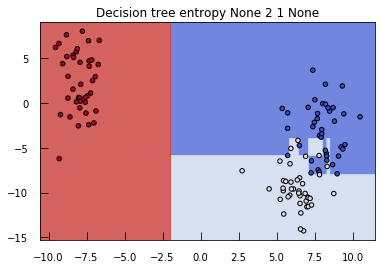

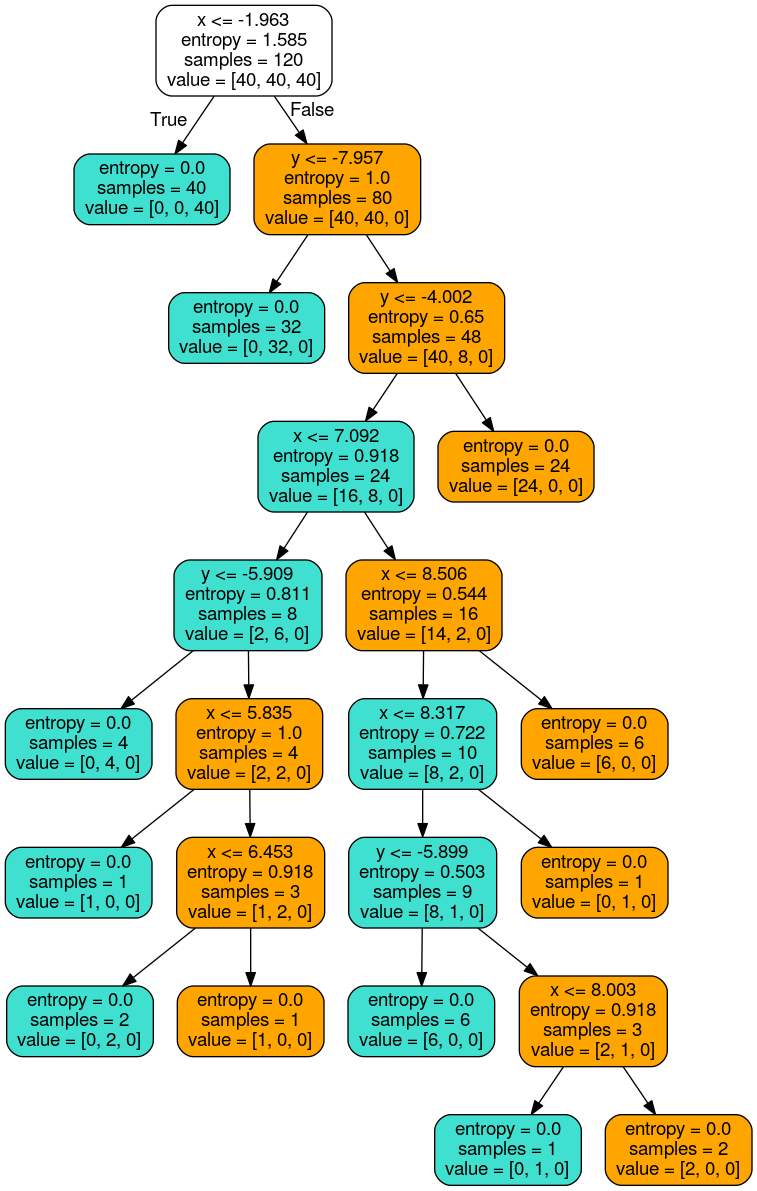

In [9]:
from utils import countour_tree

countour_tree(X_3, y_3,
              crit = 'entropy',
              maxd = None,
              min_s = 2,
              min_l = 1,
              max_f = None)
#You can see that there are 5 hyperparameters here. Let's see what they do and what they mean.
#I bet you can already guess it is going to be related to regularization....
# After X,y you have 
# * crit = 'entropy' which is one way to calculate impurity (you could also put gini here)
# * maxd : the max depth of your tree
# * min_s : the number of points that should be concerned by the making of a new rule (splitting of the nodes)
# * min_l : #of points that should be considered to make a final leaf classification
# * max_f maximum number of features to consider for making a new rule...

Well that's a really complicated and zealous tree. Look at those boundaries. Clearly if we just let it go like that it is overfitting...

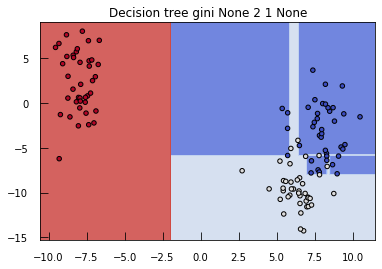

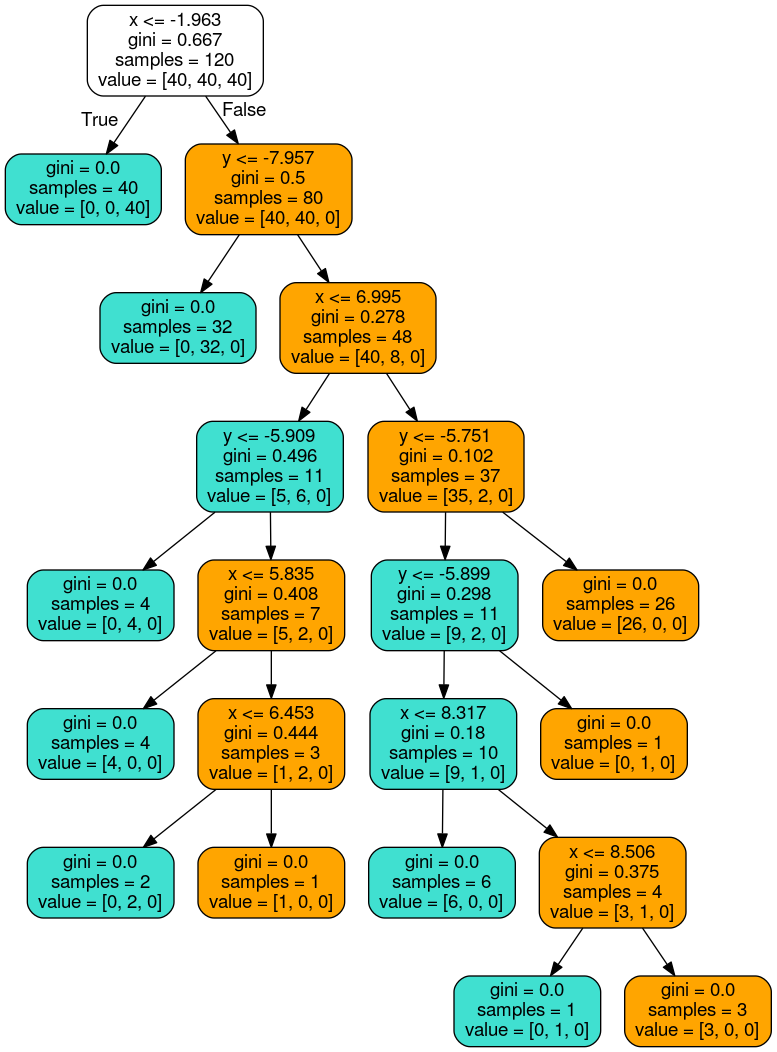

In [10]:
#using another impurity measurement
countour_tree(X_3, y_3,
              crit = 'gini',
              maxd = None,
              min_s = 2,
              min_l = 1,
              max_f = None)

Still some overfitting but it is nice to see that the boundaries are different and that impurity calculations, even if very similar, are making a difference.

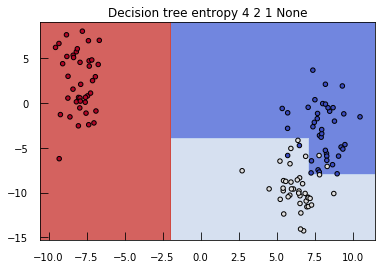

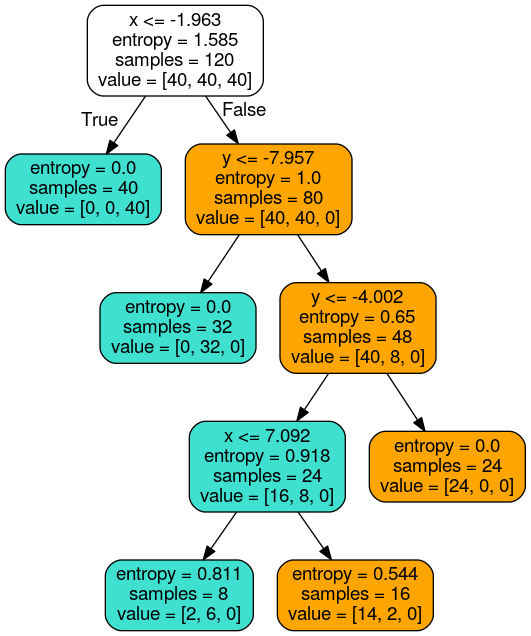

In [11]:
#Imposing a limit for the depth of the tree : how many questions you ask (here set to 4)
countour_tree(X_3, y_3,
              crit = 'entropy',
              maxd = 4,
              min_s = 2, min_l = 1, max_f = None)

Indeed only a maximum of 4 splitting events link the root to the leafs.

Here you stopped the tree at some points allowing some misslabelling instead of fitting perfectly the dataset.

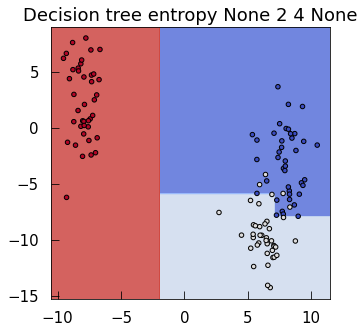

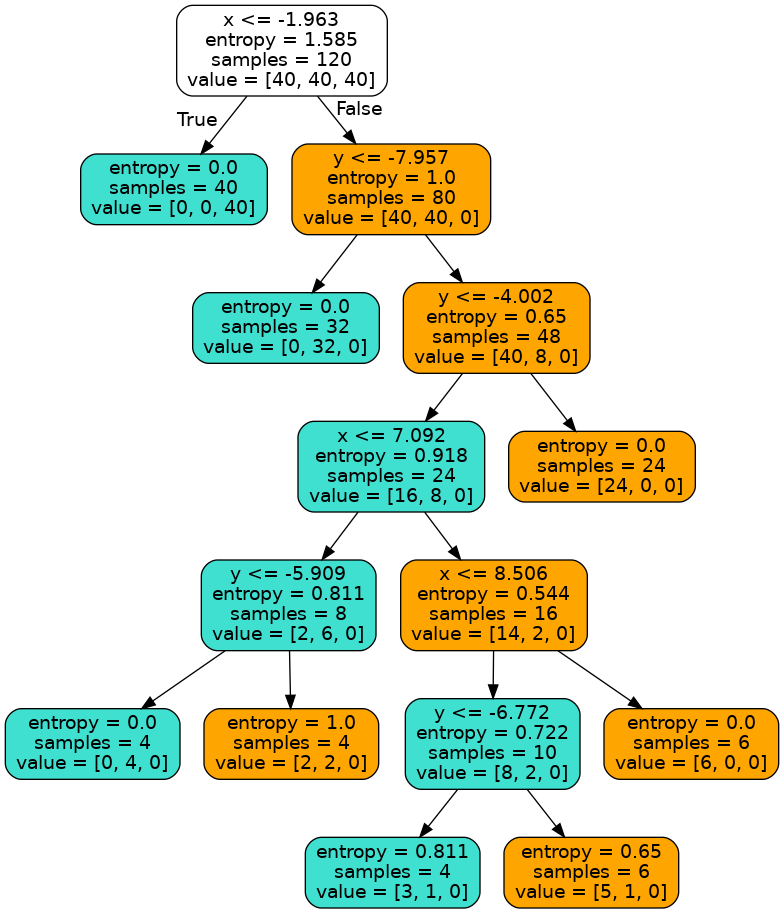

In [176]:
countour_tree(X_3, y_3,
              crit = 'entropy',
              maxd = None,
              min_s = 2,
              min_l = 4,
              max_f = None)
# I don't really have a feeling of where I should stop the tree depth. 
# But I have an understanding of this other parameter (here set to 4) called min_samples_leaf : 
# it sets the minimal number of data points that the overall chain of rules should concern. 
# Do you really wish to create a whole new set of rules to explain only one particular data point? 

Convince yourself that now rules are made for leafs of at least 4 points contrary to trees that we built before and for which you could have leaves containing only 2 points

The tree is simplified and the boundaries look more flexible.

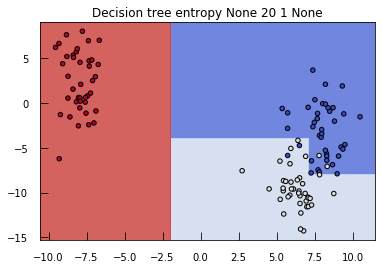

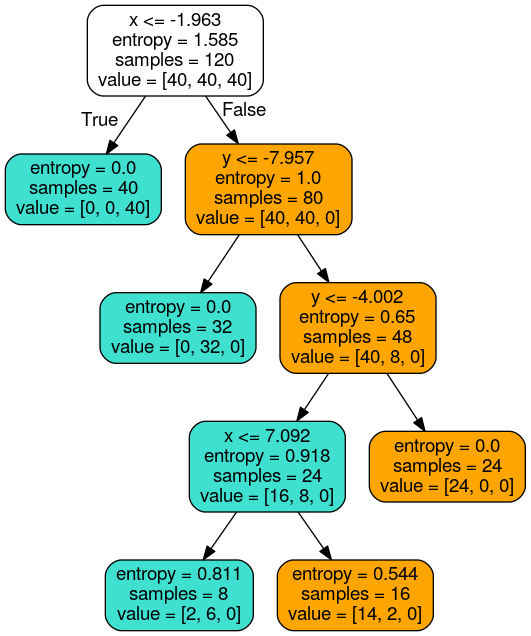

In [12]:
countour_tree(X_3, y_3,
              crit = 'entropy',
              maxd = None,
              min_s = 20,
              min_l = 1,
              max_f = None)
# Here it is the same as before but this time it applies to intermediary splittings instead of the last splitting.
# This parameter is called min_samples_split and is set to 20 here.

Check that indeed there is no node splitting concerning less than 20 points

**The interesting thing with this kind of method is that it works with all types of feature (numerical or class, I mean in theory), you don't need to rescale and it already includes non linear fitting. Moreover it is 'easy' to interpret.** 

But....(yes there is a but, there is no free lunch)

**Even with all of those hyperparamaters they are still not great on new data (inacuracy....).** We will see that in the real data example below and we will see more powerful technics based on decision tree that are more costly but generalize better.

**To do if you are curious:**

We didn't check how the maximum number of features for making a decision would affect the tree. Try it.

This hyperparameter set the number of randomly picked features to consider at each node splitting. By setting it up at None we consider all the features. But you could also fix that number as you wish or choose a known good scaling for your data which is either square root of the number of features or log2 of the number of features.

N.B. this only affects node splitting : all the features are considered when the tree is built it is just that you randomly pick from the full set at each node splitting event.

### Cancer data set

Now let's check the effects of those parameters on test and train sets accuracy. Are they acting like regularization?

#### Starting with max_depth

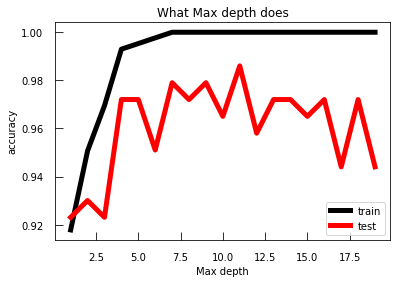

In [13]:
# testing the accuracy of the tree classifier for max depth from 1 to 20
max_dep = range(1,20)
scores_test = []
scores_train = []

for k in max_dep:
    tree = DecisionTreeClassifier(max_depth = k)
    tree.fit(X_cancer_train,y_cancer_train)
    scores_test.append(tree.score(X_cancer_test, y_cancer_test))
    scores_train.append(tree.score(X_cancer_train, y_cancer_train))

# plotting
plt.figure()
plt.xlabel('Max depth')
plt.ylabel('accuracy')
plt.title('What Max depth does')
plt.plot(max_dep, scores_train,'k-',linewidth=5,label='train')
plt.plot(max_dep, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.legend(loc='best')
plt.show()

Another great case of overfitting the data : too much depth means making more and more logical sets of rules to explain every specificity of points. So Accuracy for train reaches 1 where accuracy for test wiggles and overall goes down.

#### min_samples_splitting

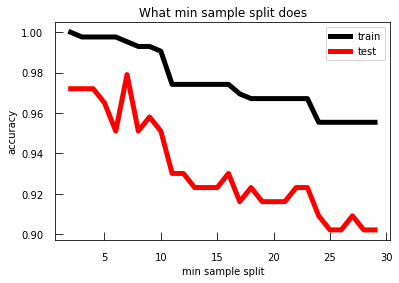

In [14]:
min_samples_spl = range(2,30)
scores_test = []
scores_train = []

for k in min_samples_spl:
    tree = DecisionTreeClassifier(min_samples_split = k)
    tree.fit(X_cancer_train,y_cancer_train)
    scores_test.append(tree.score(X_cancer_test, y_cancer_test))
    scores_train.append(tree.score(X_cancer_train, y_cancer_train))

plt.figure()
plt.xlabel('min sample split')
plt.ylabel('accuracy')
plt.title('What min sample split does')
plt.plot(min_samples_spl, scores_train,'k-',linewidth=5,label='train')
plt.plot(min_samples_spl, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.legend(loc='best')
plt.show()

Min_sample_split in our case doesn't seem to do much. But overall it is a parameter that constrains on how many samples (how specific) a rule should be applied to be envisaged.

#### min_samples_leaf

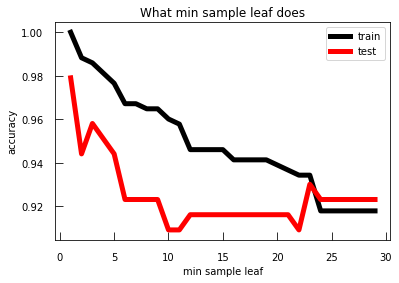

In [15]:
min_samples_lea = range(1,30)
scores_test = []
scores_train = []

for k in min_samples_lea:
    tree = DecisionTreeClassifier(min_samples_leaf = k)
    tree.fit(X_cancer_train,y_cancer_train)
    scores_test.append(tree.score(X_cancer_test, y_cancer_test))
    scores_train.append(tree.score(X_cancer_train, y_cancer_train))

plt.figure()
plt.xlabel('min sample leaf')
plt.ylabel('accuracy')
plt.title('What min sample leaf does')
plt.plot(min_samples_lea, scores_train,'k-',linewidth=5,label='train')
plt.plot(min_samples_lea, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.legend(loc='best')
plt.show()

How do you interpret this plot?

#### Let's train our model properly

In [ ]:
grid_values = {'criterion': ['entropy','gini'],
               'max_depth':np.arange(2,len(X_cancer_train),20),
               'min_samples_split':np.arange(2,len(X_cancer_train),20),
              'min_samples_leaf':np.arange(1,len(X_cancer_train),20)}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_tree_acc = GridSearchCV(DecisionTreeClassifier(), param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_tree_acc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_acc=grid_tree_acc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. accuracy): ', grid_tree_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_tree_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

y_pred_test_c=grid_tree_acc.predict(X_cancer_test)

confusion_mc_c = confusion_matrix(y_cancer_test, y_pred_test_c)
df_cm_c = pd.DataFrame(confusion_mc_c, 
                     index = [i for i in range(0,len(cancer['target_names']))], columns = [i for i in range(0,len(cancer['target_names']))])

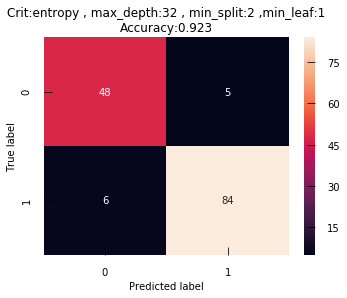

In [30]:
plt.figure(figsize=(5.5,4))
ax = sns.heatmap(df_cm_c, annot=True)
ax.set_ylim(2, 0)
ax.set_title('Crit:'+str(grid_tree_acc.best_params_['criterion'])
          +' , max_depth:'+str(grid_tree_acc.best_params_['max_depth'])+' , min_split:'+str(grid_tree_acc.best_params_['min_samples_split'])+
          ' ,min_leaf:'+str(grid_tree_acc.best_params_['min_samples_leaf'])
          +'\nAccuracy:{0:.3f}'.format(accuracy_score(y_cancer_test, 
                                                                       y_pred_test_c)))
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()

That's a very complicated tree..... And not performing as well as you would expect from something so complicated....

To get the importance of features associated to it just follow this code. You will have to retrain your model with the hyperparameters found in GridSearchCV. Indeed the direct outcome of GridSearchCV doesn't allow the usage of feature_importances...

In [26]:

tree = DecisionTreeClassifier(criterion=grid_tree_acc.best_params_['criterion'],
                             max_depth=grid_tree_acc.best_params_['max_depth'],
                             min_samples_leaf=grid_tree_acc.best_params_['min_samples_leaf'],
                             min_samples_split=grid_tree_acc.best_params_['min_samples_split'])
tree.fit(X_cancer_train, y_cancer_train)
w=tree.feature_importances_#get the weights

sorted_features=sorted([[cancer['feature_names'][i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
soted_feature_df=pd.DataFrame(sorted_features,columns=['feature','abs contribution to the model'])
soted_feature_df

Features sorted per importance in discriminative process


,feature,abs contribution to the model
0,worst perimeter,0.651357
1,worst concave points,0.192523
2,worst texture,0.063371
3,mean concave points,0.049972
4,mean smoothness,0.017910
5,radius error,0.014147
6,worst area,0.010720
7,mean radius,0.000000
8,mean texture,0.000000
9,mean perimeter,0.000000


### Iris data set

/home/wandrille/Installed_software/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Grid best parameter (max. accuracy):  {'criterion': 'entropy', 'max_depth': 32, 'min_samples_leaf': 1, 'min_samples_split': 2}
Grid best score (accuracy):  0.9464285714285714
Grid best parameter (max. accuracy) model on test:  0.9736842105263158


/home/wandrille/Installed_software/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


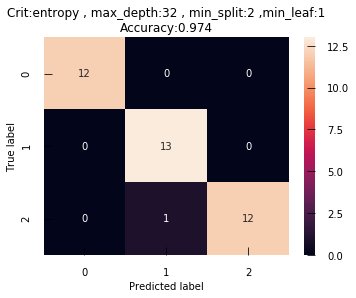

In [29]:
grid_values = {'criterion': ['entropy','gini'],
               'max_depth':np.arange(2,len(X_iris_train),10),
               'min_samples_split':np.arange(2,len(X_iris_train),10),
              'min_samples_leaf':np.arange(1,len(X_iris_train),10)}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_tree_acc = GridSearchCV(DecisionTreeClassifier(), param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_tree_acc.fit(X_iris_train, y_iris_train)

y_decision_fn_scores_acc=grid_tree_acc.score(X_iris_test,y_iris_test)

print('Grid best parameter (max. accuracy): ', grid_tree_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_tree_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

y_pred_test_i=grid_tree_acc.predict(X_iris_test)

confusion_mc_i = confusion_matrix(y_iris_test, y_pred_test_i)
df_cm_i = pd.DataFrame(confusion_mc_i, 
                     index = [i for i in range(0,len(iris['target_names']))], 
                       columns = [i for i in range(0,len(iris['target_names']))])

plt.figure(figsize=(5.5,4))
ax = sns.heatmap(df_cm_i, annot=True)
ax.set_ylim(3,0)
plt.title('Crit:'+str(grid_tree_acc.best_params_['criterion'])
          +' , max_depth:'+str(grid_tree_acc.best_params_['max_depth'])+' , min_split:'+str(grid_tree_acc.best_params_['min_samples_split'])+
          ' ,min_leaf:'+str(grid_tree_acc.best_params_['min_samples_leaf'])
          +'\nAccuracy:{0:.3f}'.format(accuracy_score(y_iris_test, 
                                                                       y_pred_test_i)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Random Forest <a class="anchor" id="Random-Forest"></a>

**the Random Forest algorithm relies on two main concepts : producing/training many trees all different from an element of randomness, and then asking all the trees what their prediction on new points is and choose a way to agglomerate those different predicitions (mainly averaging).** 

Those elements of randomness concern the **training dataset via bootstrapping methods** and also only using a **random subset of features for creating the trees in the forest** (this is different from setting a max_feature this time!). Each  bootstrap part is going to be used to **train a new tree in the forest** (and this tree will be build only with the randomly drawn subset of parameters).

**Bootstrapping methods are sampling methods in which you randomly draw a subsample of your data**. You keep the same size as the initial data though. This is possible because duplicates of points are allowed. This subsample is then used to train a tree which will have also a subsample of the features only. 

I am sure you can see intuitively how that is going to help generalization of our model.

So now you have all the parameters seen before for individually creating each tree of the forest, but you also have a parameter controlling the number of trees in your forest.


**In the following plots I am plotting the result for a random forest algorithm and compare it to a single decision tree sharing the same hyperparameters value than the one used in the random forest**.


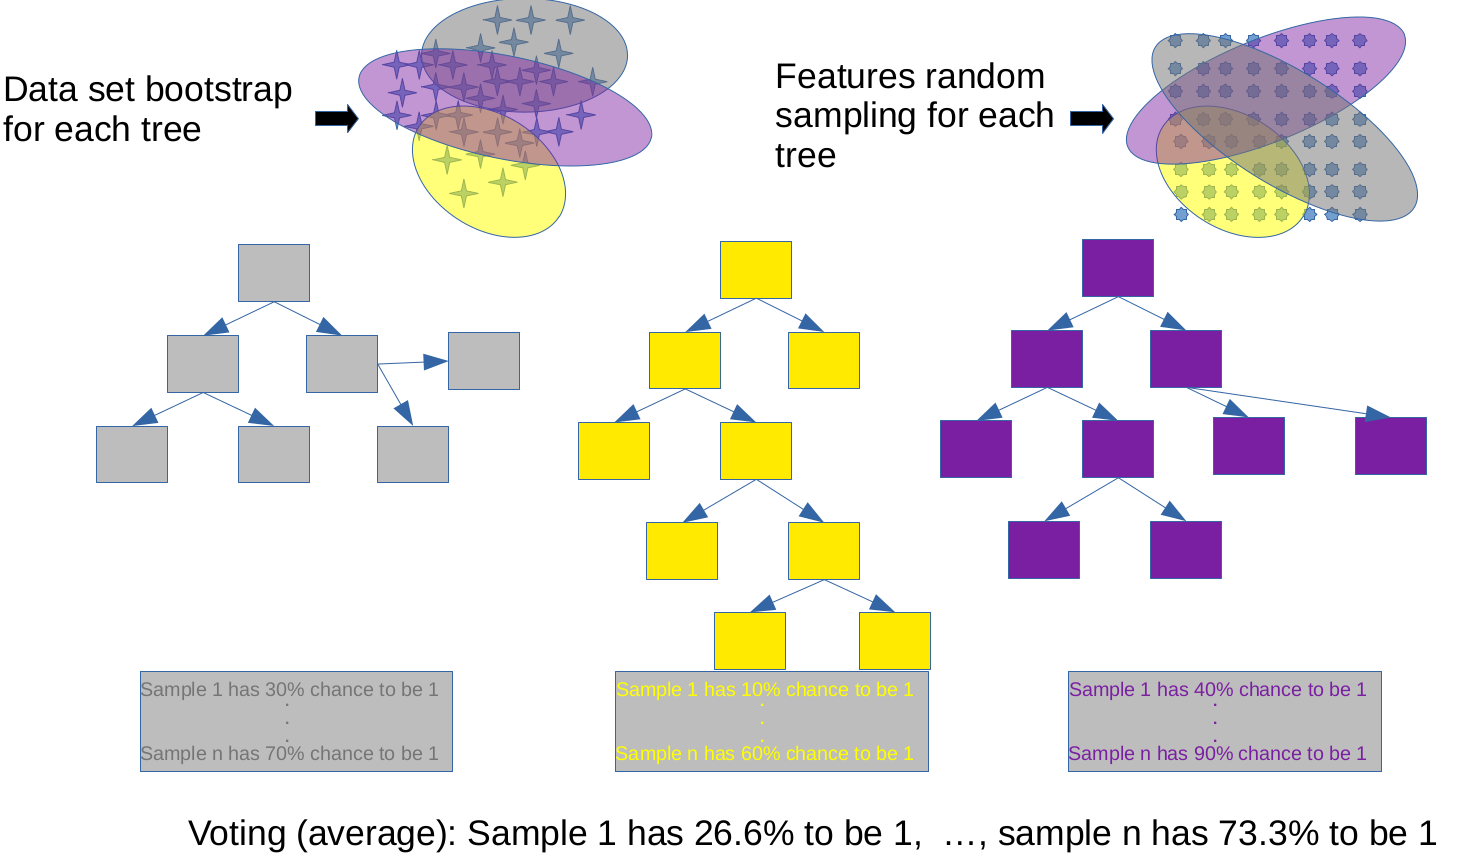

In [200]:
Image('RF.png')

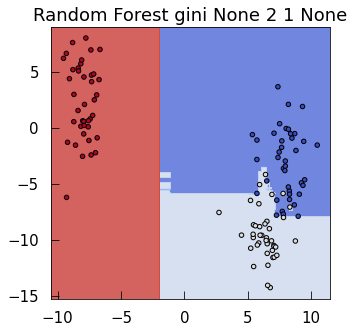

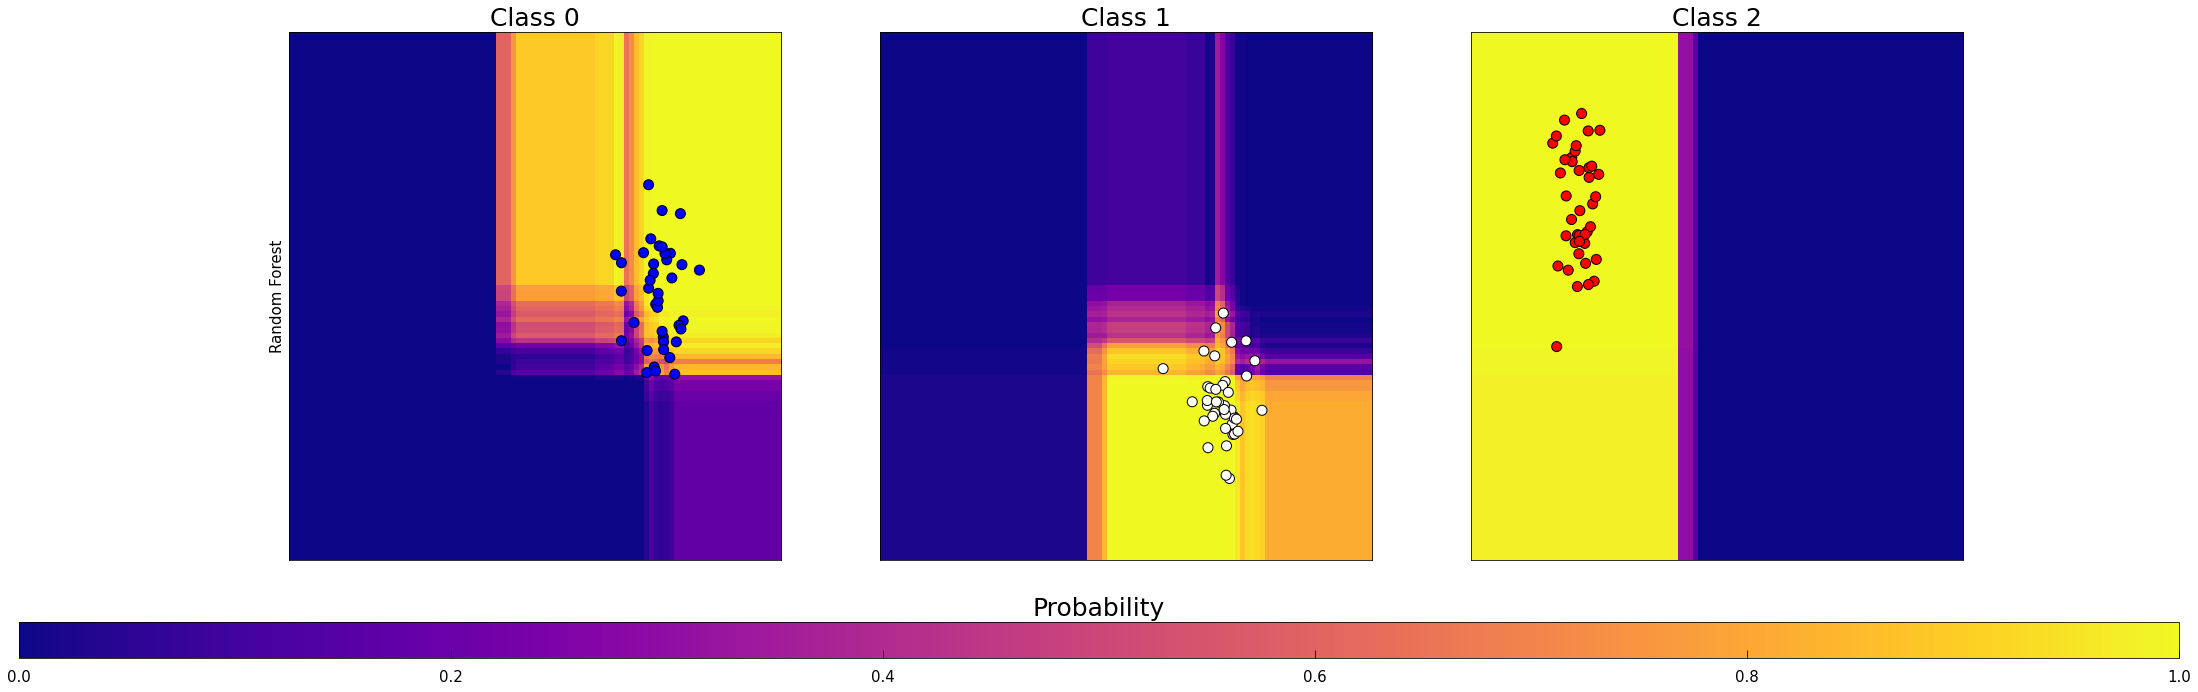

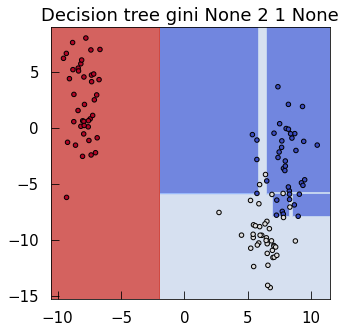

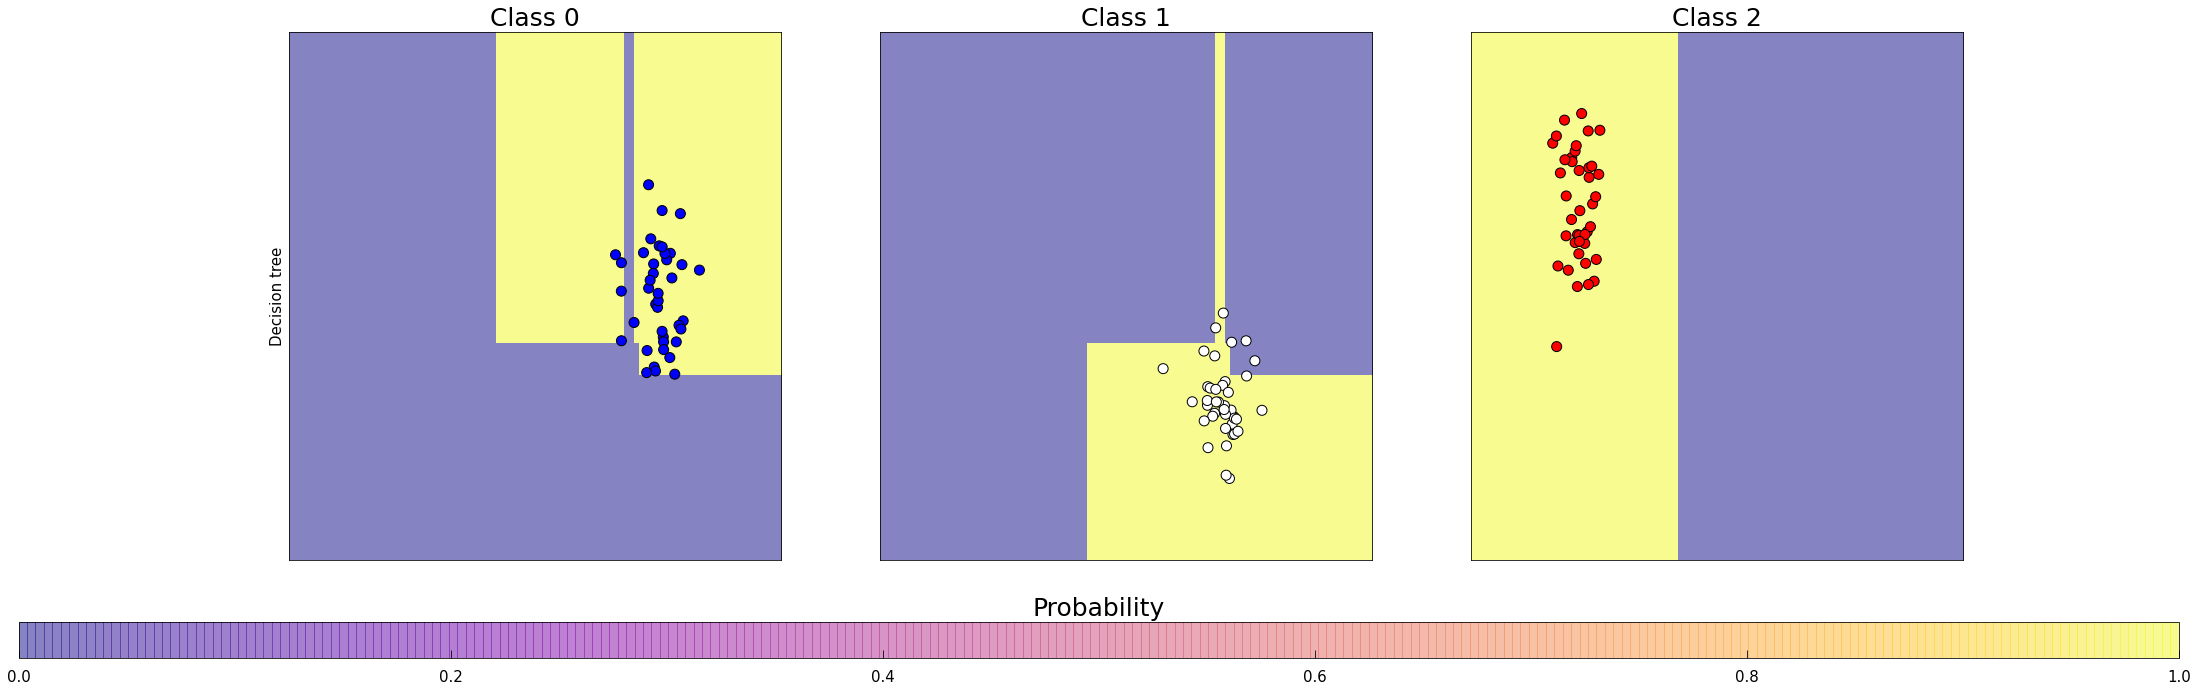

In [184]:
from utils import countour_RF
countour_RF(X_3, y_3,100,'gini',None,2,1,None)#Same as for decision tree except that we have here one more hyperparameter, here
#put to 100 and that represents the number of bootstraps (number of trees trained and then participating to the vote)

See how in the case of random forest the iso-probability lines are less binary than in the case of the decision tree? 

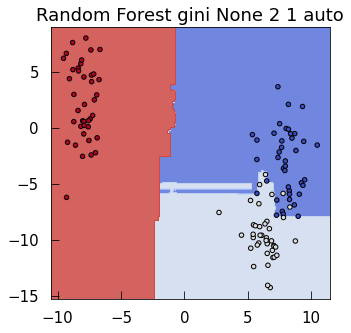

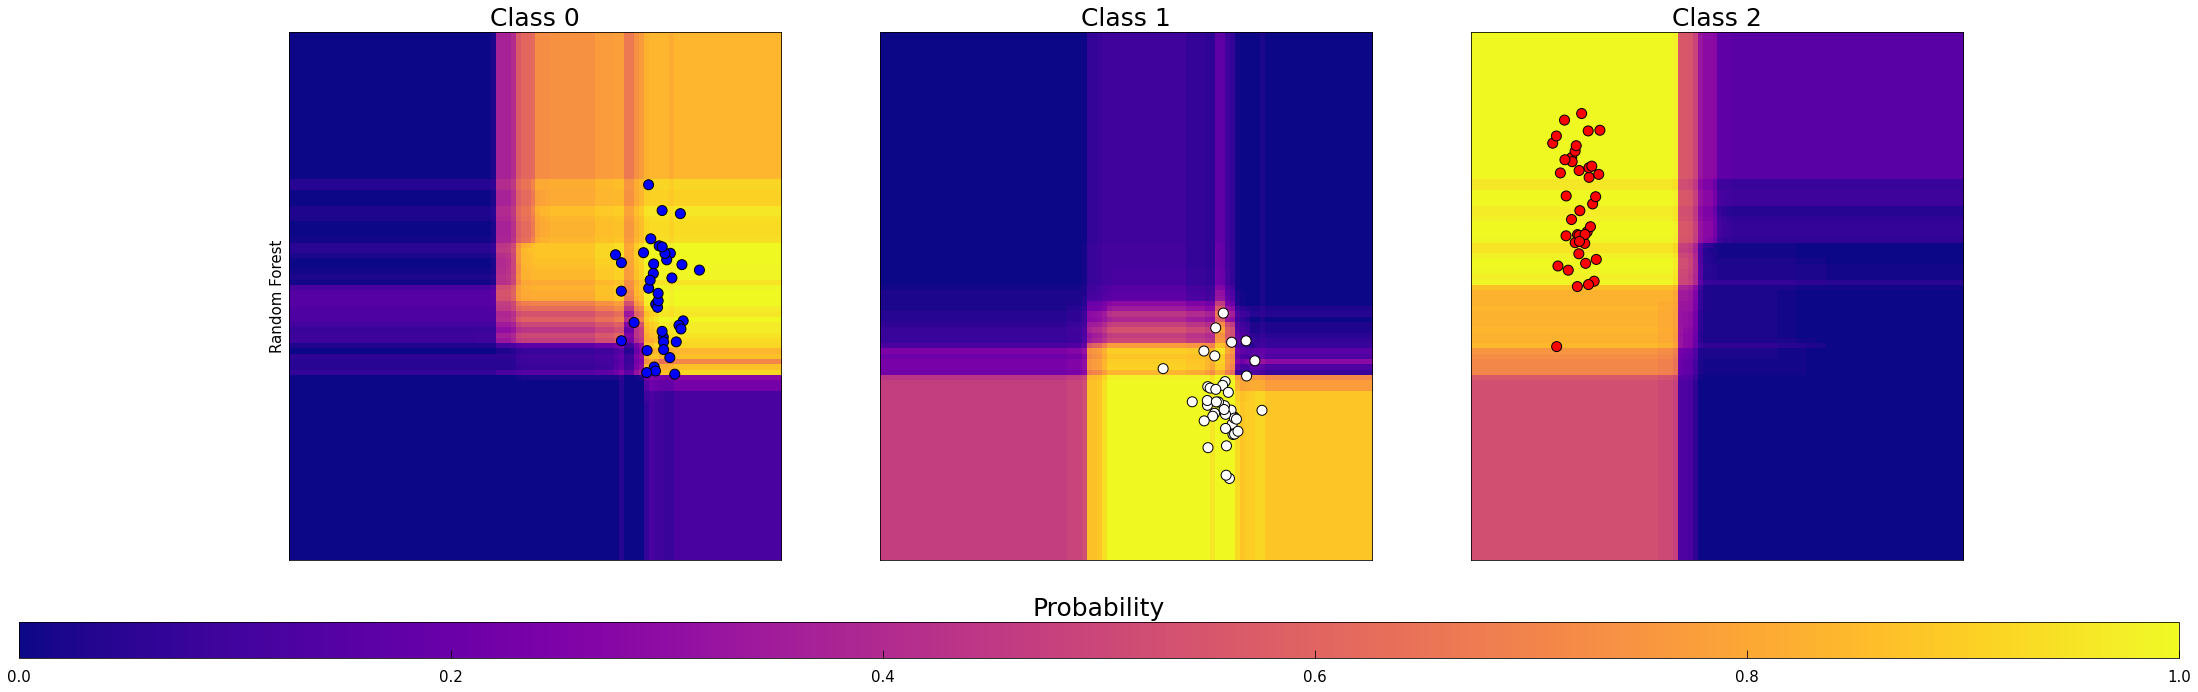

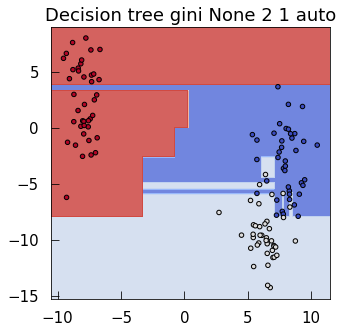

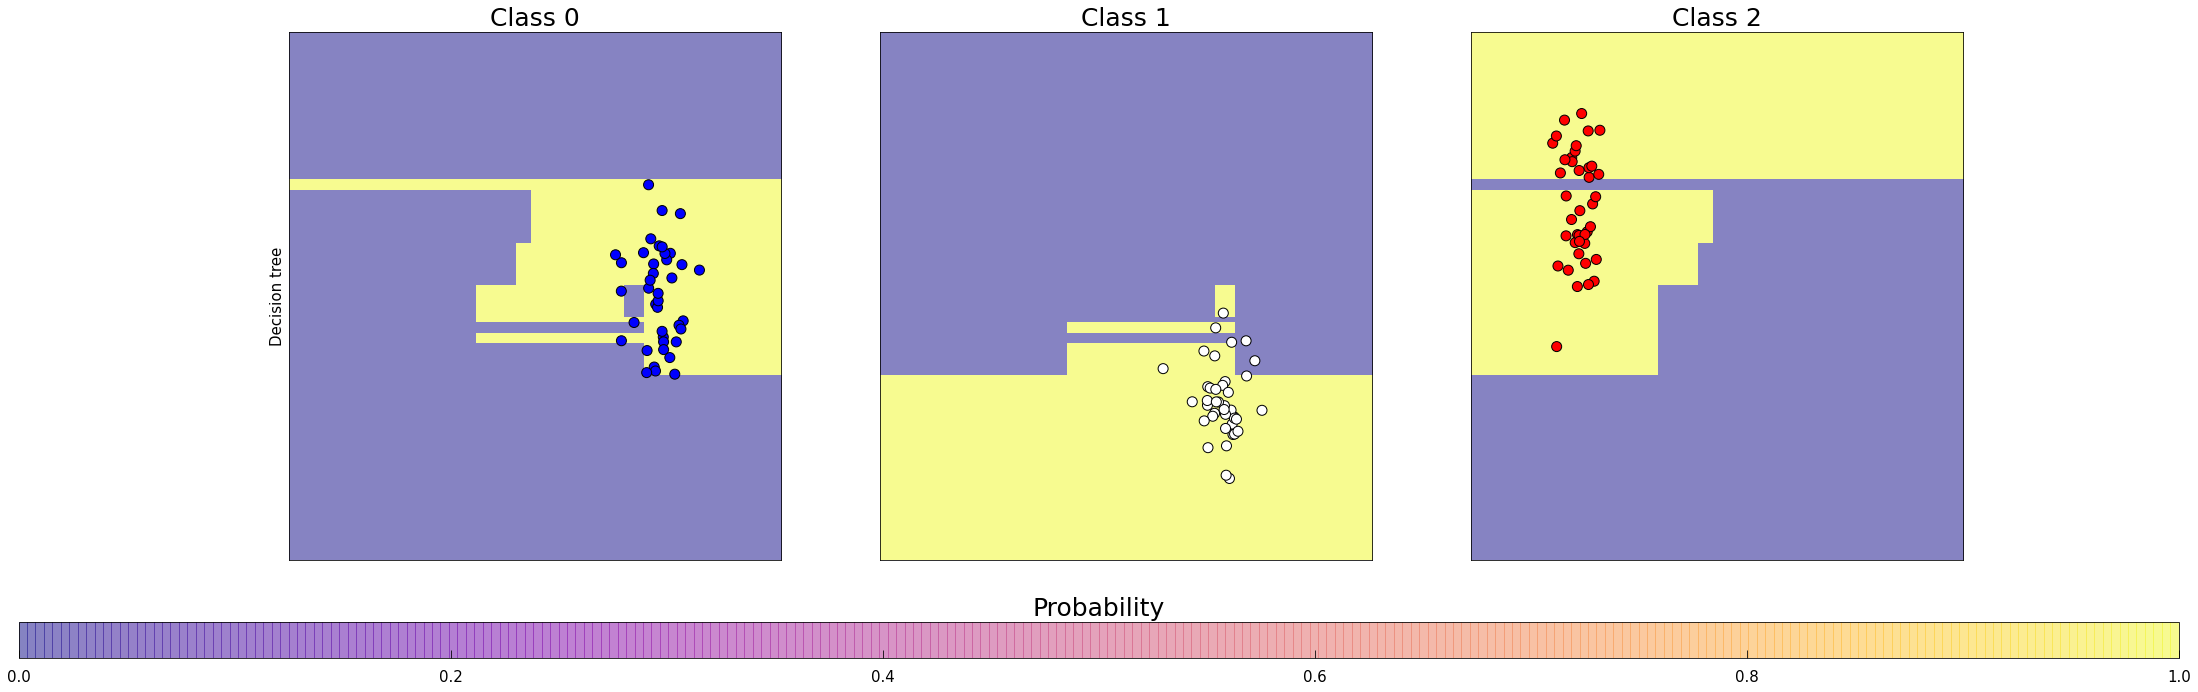

In [185]:
countour_RF(X_3, y_3,100,'gini',None,2,1,'auto')# The difference here is that we set the max number of feature to split node to auto
#(square root of the total number of features). Before with None we were considering all the feature for node splitting.

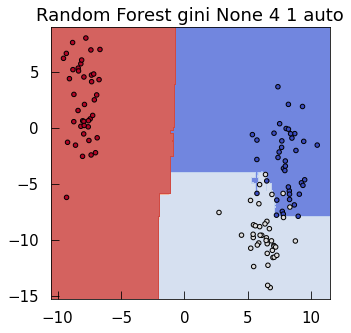

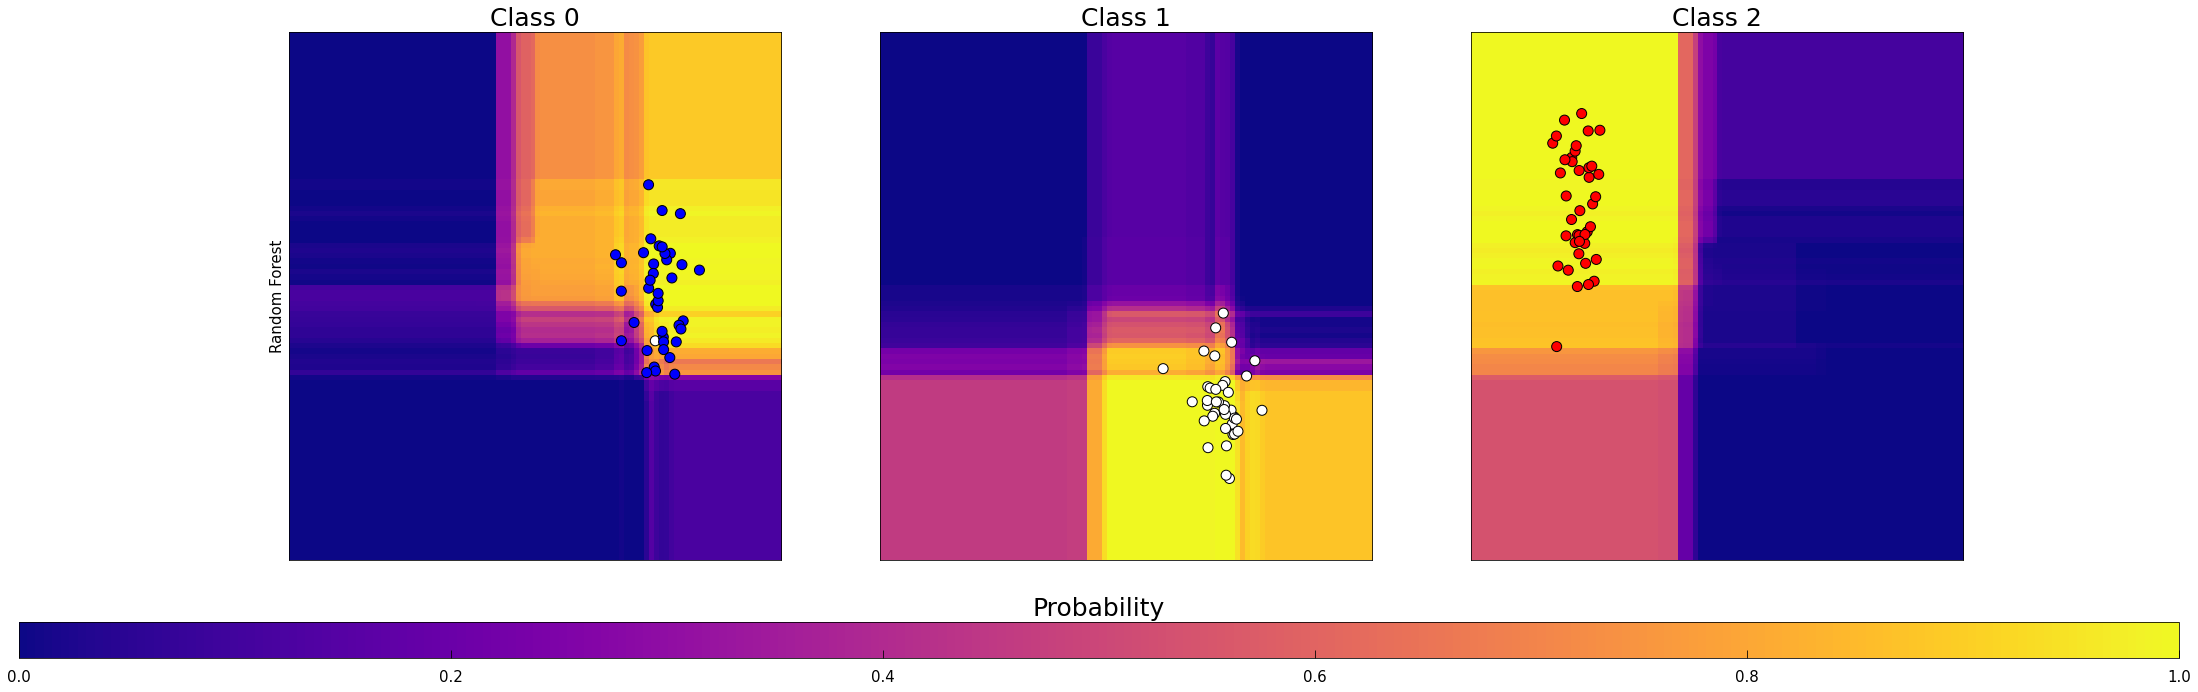

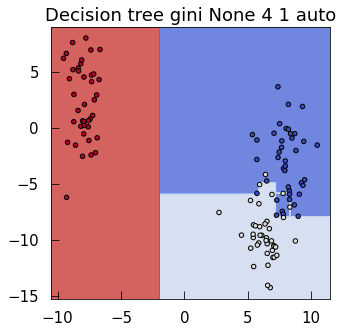

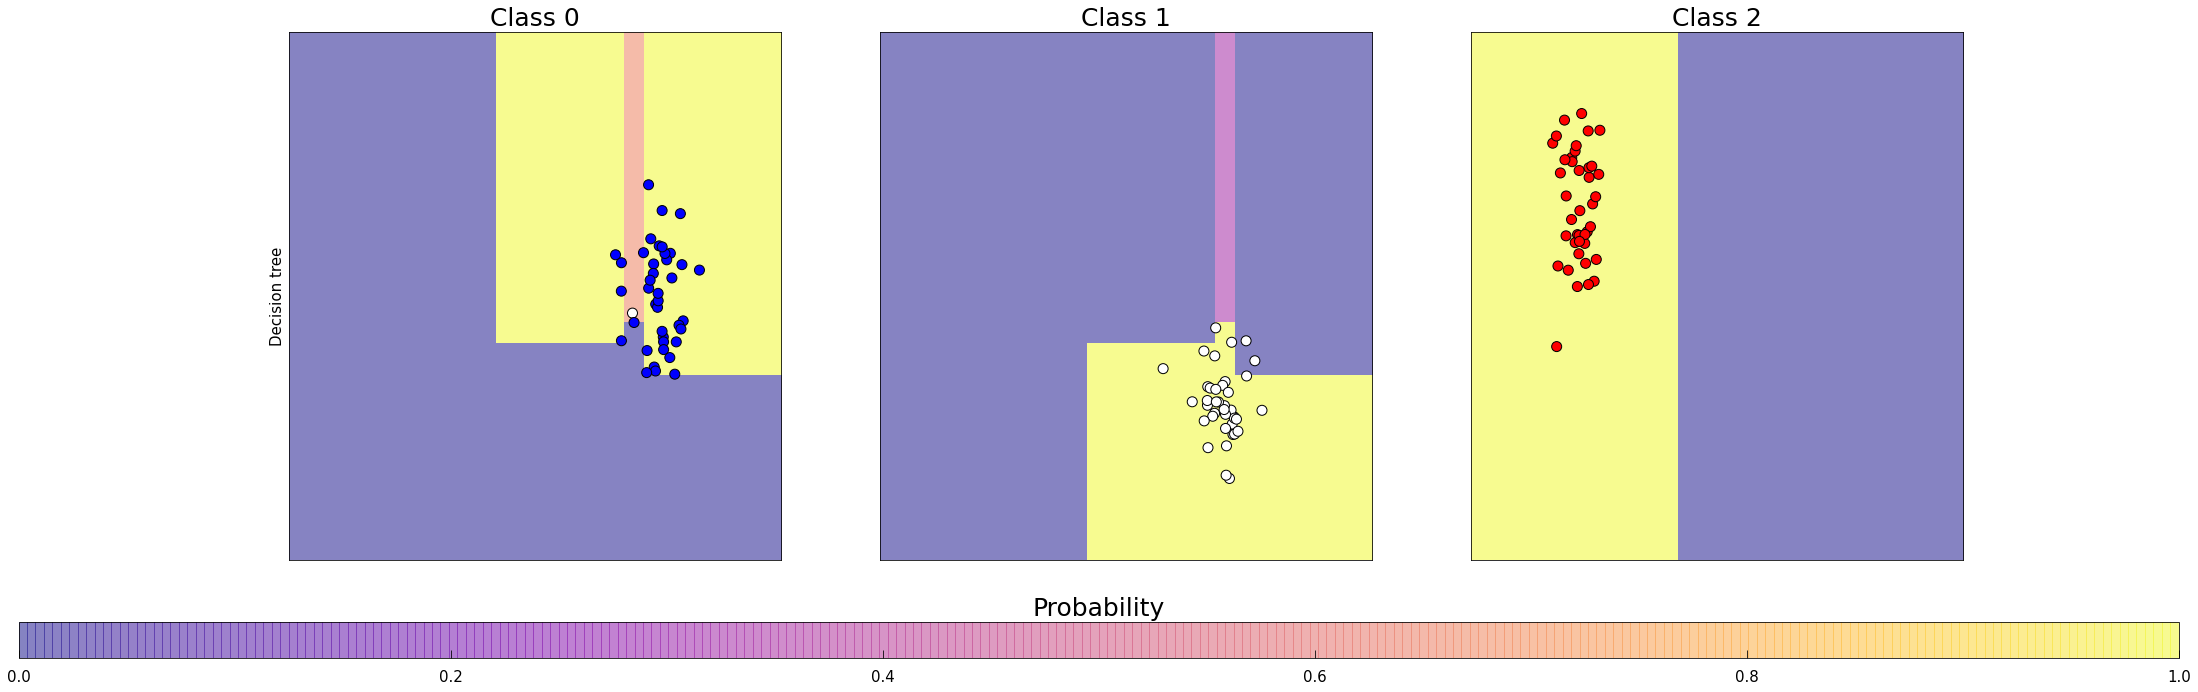

In [186]:
countour_RF(X_3, y_3,100,'gini',None,4,1,'auto')# We change min sample split from 2 to 4, that would be equivalent to add some regularization.

We added a little bit of regularization in the single tree and so we can start to see less sharp borders. For the random forest it changes a bit the countours.

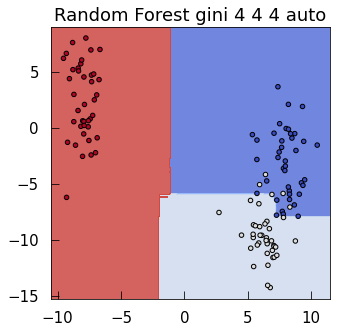

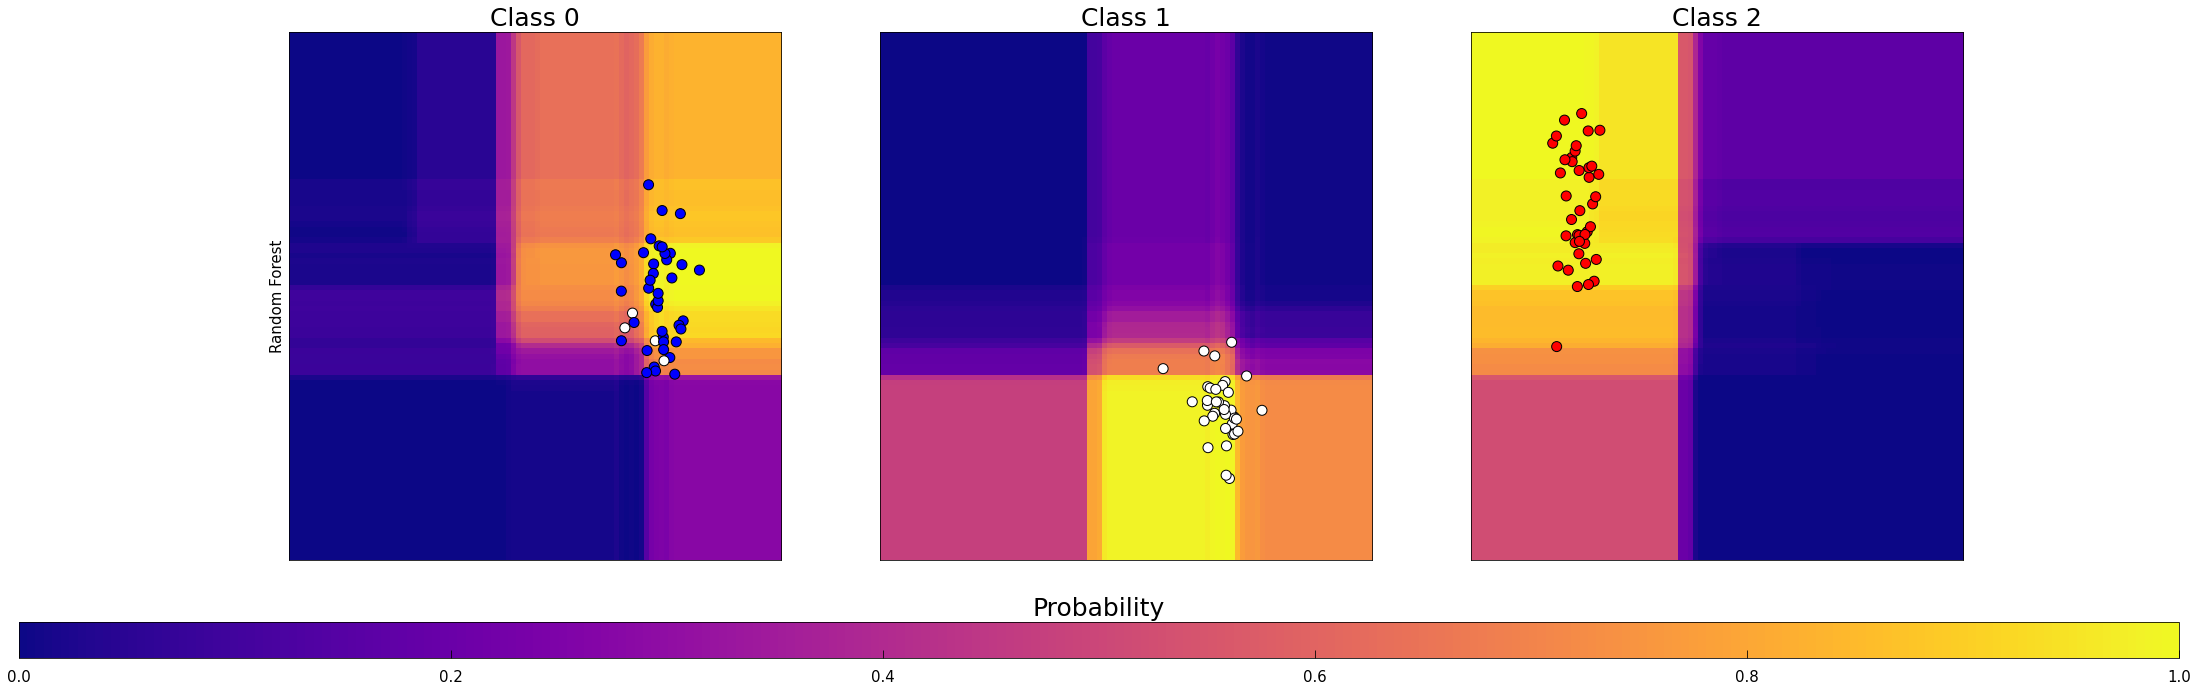

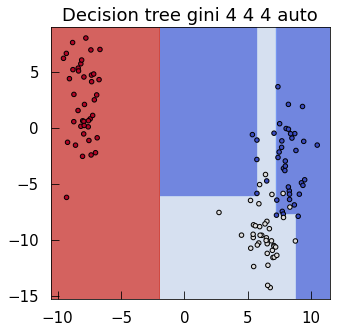

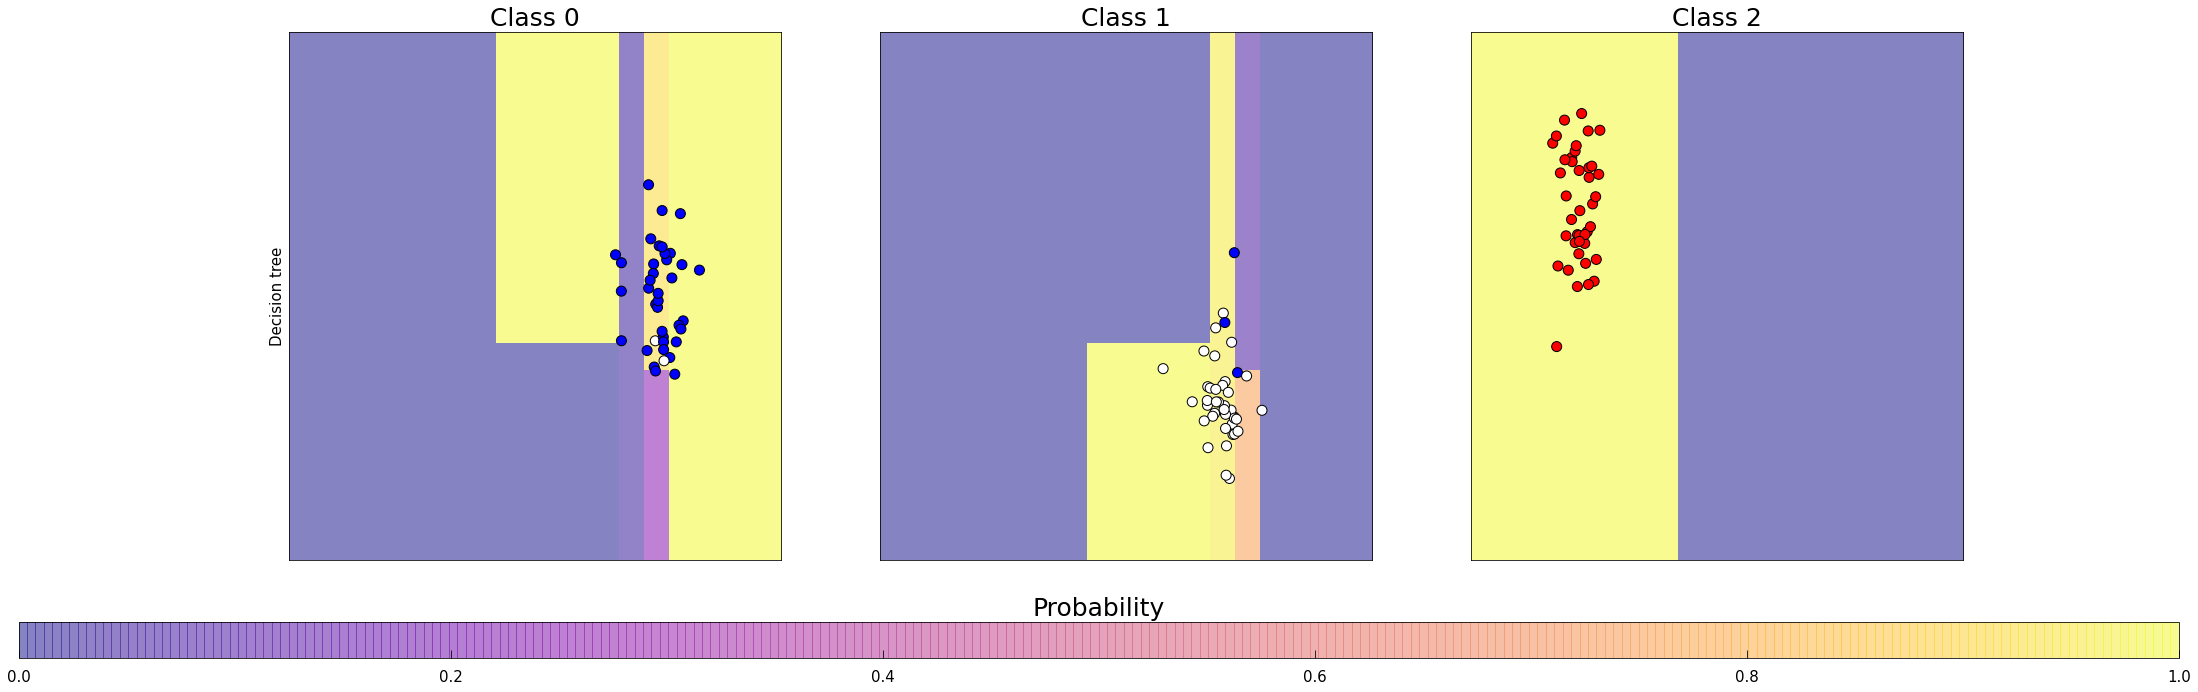

In [187]:
countour_RF(X_3, y_3,100,'gini',4,4,4,'auto')#Even more regularization, now we are more stringent on the size of the leaf and the 
#max depth of the individual trees

### Cancer data set

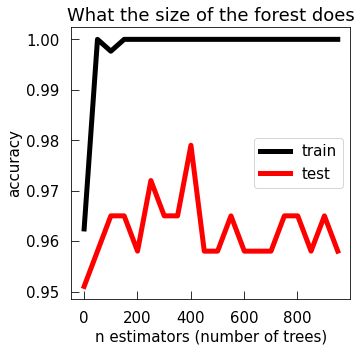

In [188]:
n_est=np.arange(1,1000,50) 
scores_test = []
scores_train = []

for k in n_est:
    tree = RandomForestClassifier(n_estimators = int(k))
    tree.fit(X_cancer_train,y_cancer_train)
    scores_test.append(tree.score(X_cancer_test, y_cancer_test))
    scores_train.append(tree.score(X_cancer_train, y_cancer_train))

plt.figure()
plt.xlabel('n estimators (number of trees)')
plt.ylabel('accuracy')
plt.title('What the size of the forest does')
plt.plot(n_est, scores_train,'k-',linewidth=5,label='train')
plt.plot(n_est, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.legend(loc='best')
plt.show()

Here 50 trees is probably a good guess as it is where test accuracy peaks without being insanely high for the train set.

Grid best parameter (max. accuracy):  {'criterion': 'gini', 'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 201}
Grid best score (accuracy):  0.9671135430916552
Grid best parameter (max. accuracy) model on test:  0.951048951048951


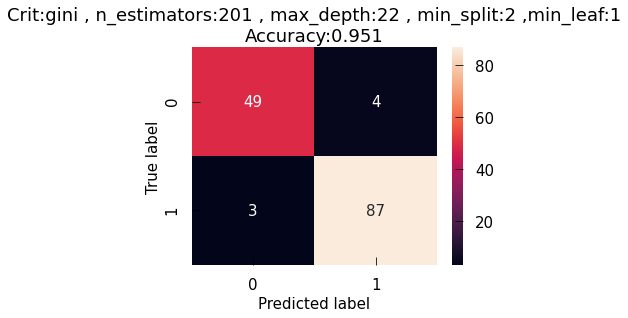

In [189]:
from sklearn.metrics import confusion_matrix,accuracy_score


grid_values = {'criterion': ['entropy','gini'],
               'n_estimators':np.arange(1,500,100), 
               'max_depth':np.arange(2,int(len(X_cancer_train)/10),20),
               'min_samples_split':np.arange(2,int(len(X_cancer_train)/10),20),
              'min_samples_leaf':np.arange(1,int(len(X_cancer_train)/10),20)}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_tree_acc = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_tree_acc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_acc=grid_tree_acc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. accuracy): ', grid_tree_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_tree_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

y_pred_test_c=grid_tree_acc.predict(X_cancer_test)

confusion_mc_c = confusion_matrix(y_cancer_test, y_pred_test_c)
df_cm_c = pd.DataFrame(confusion_mc_c, 
                     index = [i for i in range(0,len(cancer['target_names']))], columns = [i for i in range(0,len(cancer['target_names']))])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm_c, annot=True)
plt.title('Crit:'+str(grid_tree_acc.best_params_['criterion'])
          +' , n_estimators:'+str(grid_tree_acc.best_params_['n_estimators'])
          +' , max_depth:'+str(grid_tree_acc.best_params_['max_depth'])+' , min_split:'+str(grid_tree_acc.best_params_['min_samples_split'])+
          ' ,min_leaf:'+str(grid_tree_acc.best_params_['min_samples_leaf'])
          +'\nAccuracy:{0:.3f}'.format(accuracy_score(y_cancer_test, 
                                                                       y_pred_test_c)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [190]:
RF = RandomForestClassifier(criterion=grid_tree_acc.best_params_['criterion'],
                              n_estimators=grid_tree_acc.best_params_['n_estimators'],
                             max_depth=grid_tree_acc.best_params_['max_depth'],
                             min_samples_leaf=grid_tree_acc.best_params_['min_samples_leaf'],
                             min_samples_split=grid_tree_acc.best_params_['min_samples_split'],n_jobs=-1)
RF.fit(X_cancer_train, y_cancer_train)
w=RF.feature_importances_#get the weights

sorted_features=sorted([[cancer['feature_names'][i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
soted_feature_df=pd.DataFrame(sorted_features,columns=['feature','abs contribution to the model'])
soted_feature_df

Features sorted per importance in discriminative process


,feature,abs contribution to the model
0,worst perimeter,0.138217
1,mean concave points,0.113482
2,worst area,0.108449
3,worst concave points,0.107529
4,worst radius,0.105945
5,mean perimeter,0.051818
6,mean concavity,0.051492
7,area error,0.047557
8,worst concavity,0.041071
9,mean radius,0.037002


# ADA Boost <a class="anchor" id="Ada-Boost"></a>

**This time again, you have a forest of trees : actually of stumps. ADA boost only consider the simplest type of trees : one feature with a yes or no question.** Another difference is that now, unlike random forest in which all trees had the same power in the final decision, **in ADA boost stumps have different contributions in the final decision.** One last crucial difference between Random Forest and ADA boost is that in random forest each tree is created independantly of each other whereas in **ADA boost there is an order and a logical reason that links two contigus stumps.**

**In fact each stump is made by taking the previous stumps mistakes into account and try to remedy to it.** How does it do that? By applying an importance weight on each sample. At the beginning of the algorithm all the samples have the same weight but then after the first stump, the missclassified points will have a higher weight so that the next stumps really focuses on predicting them well this time.

**The stumps have more to say in the classification if they have been better at classifying in general!** Funny thing (or not...) is that, if a specific stump has missclassified 100 % of the data it is actually a really good classifier if you decide to just reverse the labels.... What I am trying to say here is that the amount of vote credibility that a stump is given is not really how accurate it is but more how far from a random classifier it is, because again if you are 100% wrong it means that you have discovered a pattern but you misinterpreted it.

The actual voting weight for the $t^{th}$ stump is of the form $\alpha_{t}=L*log(\frac{1-total-weigthed-error_{t}}{total-weigthed-error_{t}})$, where L is the learning rate.

Also, since the different trees are not created in parallel like in random forest, and that you need to take into account errors from previous iterations, how do you choose the strength of the bias for the next iteration? This is similar to a learning rate in usual optimization problem. In Adaboost the error is put in a exponential (so the loss function is called exponential). You are trying to minimize the loss function and you do so at some rate called learning rate. And so you guessed it, this is our new hyperparameter.

The actual update of the importance of dataset points according to the errors of the stump at some iteration is following the the same formula as voting. Then as explained before this error is put in an exponential and serve as the updated weights.

$w^{t+1}_{i}=w^{t}_{i}\exp{\alpha_{t+1} \text{ if } stump_{t+1} \text{ made a mistake for point i } }$ 

those weights are then normalized.

And at the end classification is made following a weighted average of the stumps:

$G(x)=\sum^{T}_{t=1}\alpha_{t}G_{t}(x)$


But rejoyced!! Since we are only using stumps we already got rid of all the other parameters describing the tree topology (max depth, min samples split, min leaf split ).



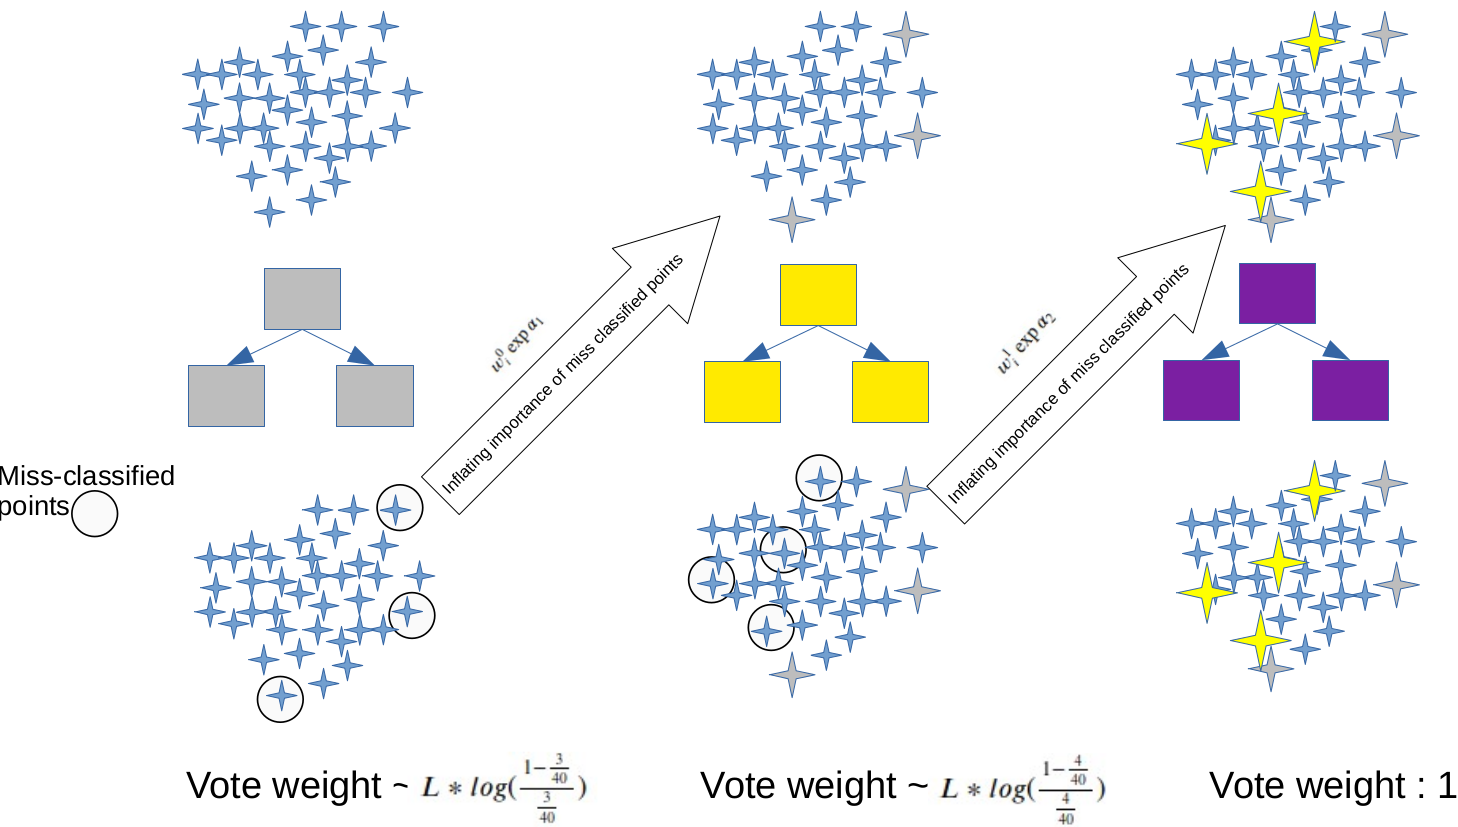

In [201]:
Image('ADA.png')

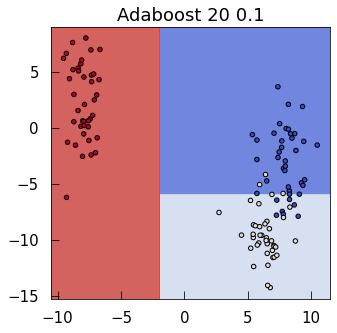

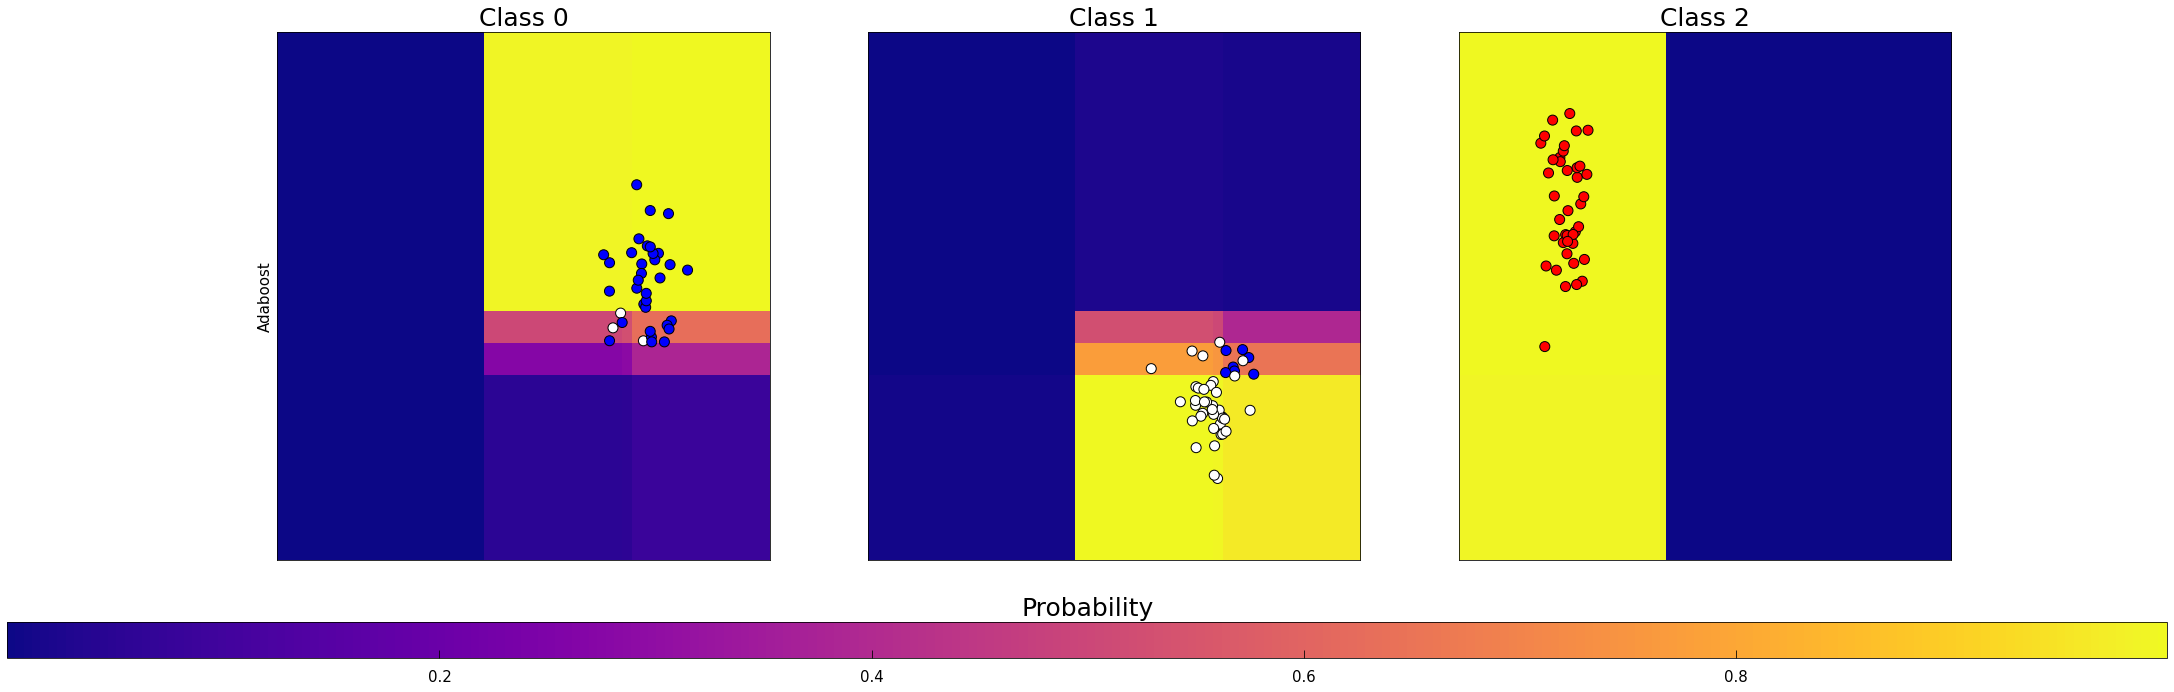

In [191]:
from utils import countour_ADA
countour_ADA(X_3, y_3,20,0.1)#20 stumps, learning rate is 0.1

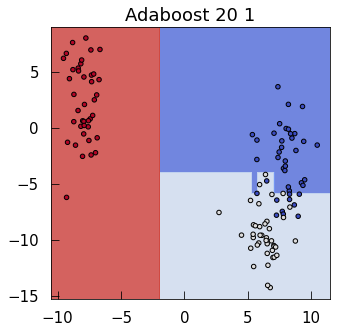

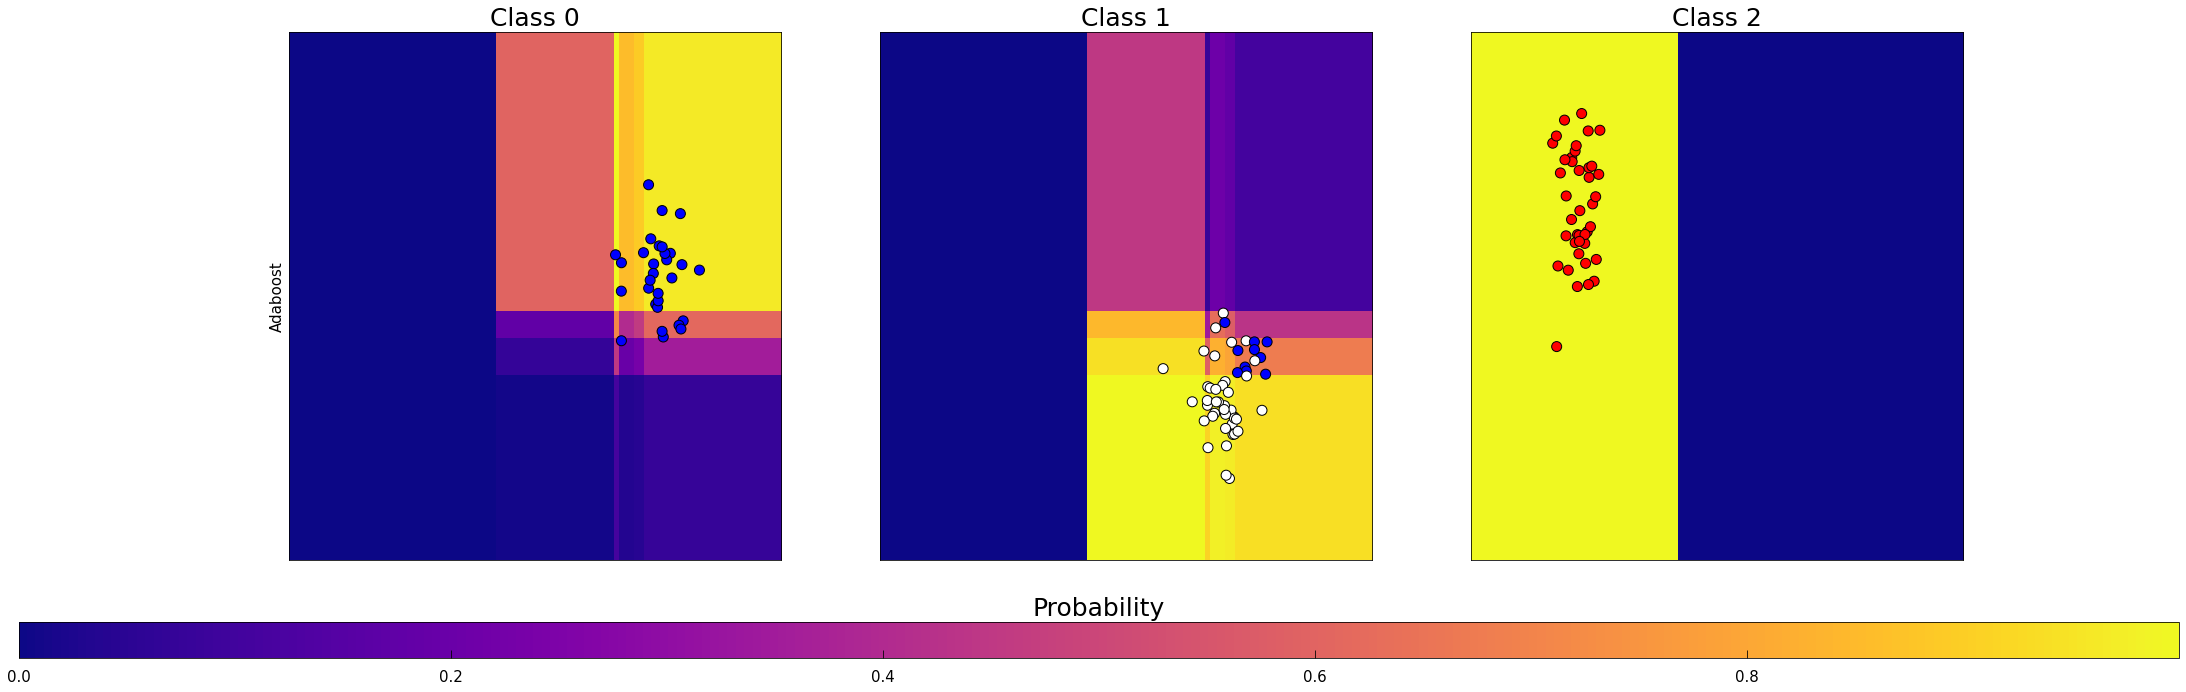

In [192]:

countour_ADA(X_3, y_3,20,1)#learning rate is 1

### Cancer dataset

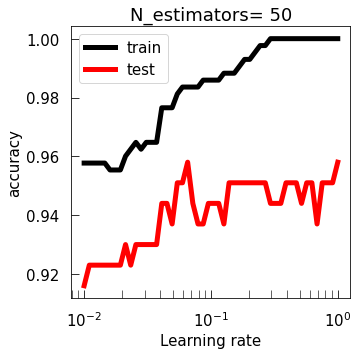

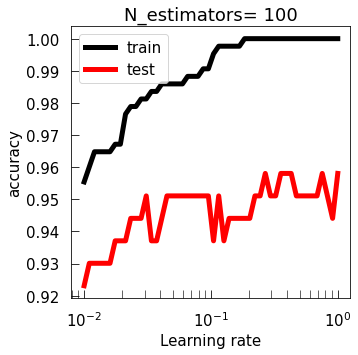

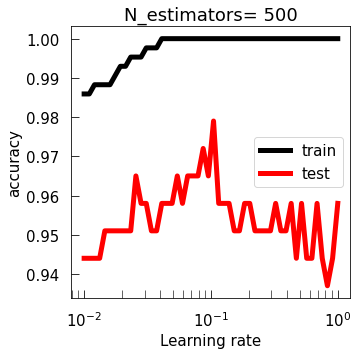

In [193]:
l_rate=np.logspace(-2,0,50) 

n_estimator=[50,100,500]
for j in n_estimator:
    scores_test = []
    scores_train = []
    for k in l_rate:
        tree = AdaBoostClassifier(n_estimators=j,learning_rate=k)
        tree.fit(X_cancer_train,y_cancer_train)
        scores_test.append(tree.score(X_cancer_test, y_cancer_test))
        scores_train.append(tree.score(X_cancer_train, y_cancer_train))

    plt.figure()
    plt.xlabel('Learning rate')
    plt.ylabel('accuracy')
    plt.xscale('log')
    plt.title('N_estimators= '+str(j))
    plt.plot(l_rate, scores_train,'k-',linewidth=5,label='train')
    plt.plot(l_rate, scores_test,'r-',linewidth=5,label='test')
    #plt.xticks([0,20,40,60,80,100])
    plt.legend(loc='best')
    plt.show()

The two hyperparameters number of of stumps and learning rate are actually interdependant. The law associating the two is not obvious but just keep in mind that if number of stumps is large you don't need a big learning rate.

Grid best parameter (max. accuracy):  {'learning_rate': 0.06999999999999999, 'n_estimators': 101}
Grid best score (accuracy):  0.9671135430916553
Grid best parameter (max. accuracy) model on test:  0.951048951048951


Text(0.5, 5.0, 'Predicted label')

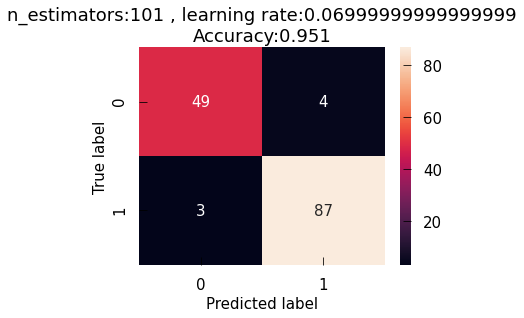

In [194]:
from sklearn.metrics import confusion_matrix,accuracy_score
#DecisionTreeClassifier(criterion=crit,max_depth=maxd,min_samples_split=min_s,min_samples_leaf=min_l)

grid_values = {'n_estimators':np.arange(1,1000,50), 
               'learning_rate':np.arange(0.01,0.1,0.01)
               }# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_tree_acc = GridSearchCV(AdaBoostClassifier(), param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_tree_acc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_acc=grid_tree_acc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. accuracy): ', grid_tree_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_tree_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

y_pred_test_c=grid_tree_acc.predict(X_cancer_test)

confusion_mc_c = confusion_matrix(y_cancer_test, y_pred_test_c)
df_cm_c = pd.DataFrame(confusion_mc_c, 
                     index = [i for i in range(0,len(cancer['target_names']))], columns = [i for i in range(0,len(cancer['target_names']))])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm_c, annot=True)
plt.title('n_estimators:'+str(grid_tree_acc.best_params_['n_estimators'])
          +' , learning rate:'+str(grid_tree_acc.best_params_['learning_rate'])
          +'\nAccuracy:{0:.3f}'.format(accuracy_score(y_cancer_test, 
                                                                       y_pred_test_c)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Boosted gradient <a class="anchor" id="Boosted-Gradient"></a>

As you can already imagine from the name in the case of boosted gradient the optimization of our algorithm follow the gradient of a loss function (or of a maximum likelihood!).

Just like ADAboost and random forest, boosted gradient **creates many trees** and datasets toward making its decision. Just like ADAboost the next built tree **is taking into account the errors from the previous one**. **Contrary to those other methods at the end of the algo you only have one tree which has been constructed to optimize classification (and not a quorum of trees voting)**. It is thus a bit different than having at the end only a single combination of stumps or a vote of a forest of trees.

So what gradient are we talking about? Of course the gradient of a loss function. This loss function is quite different from the one used in AdaBoost. To understand it, we have to realize that the only thing boosted gradient does (when used for classification), **is to transform the leafs scores of its trees into log odd ratio! Basically it is switching gear between a loss function that aims at at differentiating between class, toward a loss function that tries to fit a function (regression)**.It is a smart way to do highly non linear classification rules, based on logistic regression!!!!! It then follows the gradient of features combinations (tree) that minimize the difference between the predicted log odds and its labeled values (1 or 0).

We will see later that regression gradient boost do the same : follow the combinations of features (tree) and minimize the error of the function outcome prediction to the real value.

It might seems a little artifical to do so because here we need one more step to transform a problem of classification (for which the algo has not really been optimized for) to a regression problem... That consideration will be reversed later on when we will use algo obviously suitable for classification in the context of regression...


**In term of hyperparameters it is a concatenation of all what we have see before. All what is needed to describe a decision tree, a number of iteration and a learning rate.** 

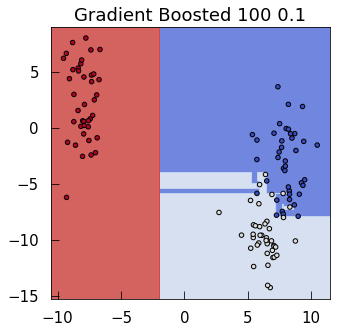

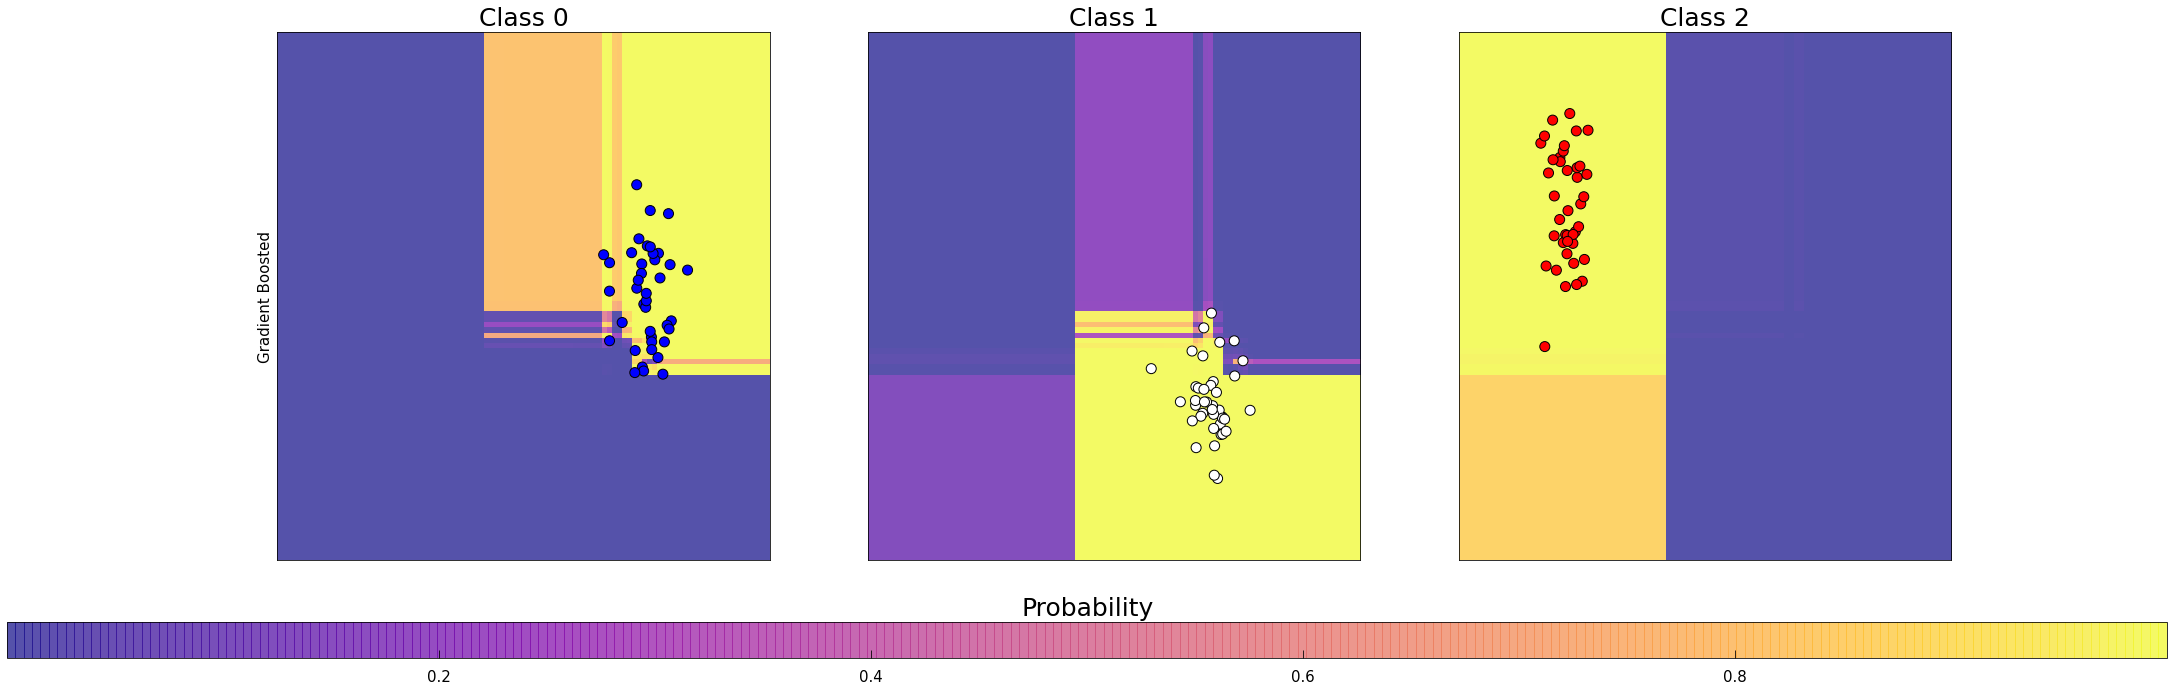

In [195]:
from utils import countour_BG
countour_BG(X_3, y_3,100,0.1,4,2,2,'auto')

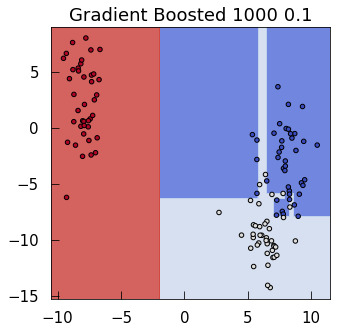

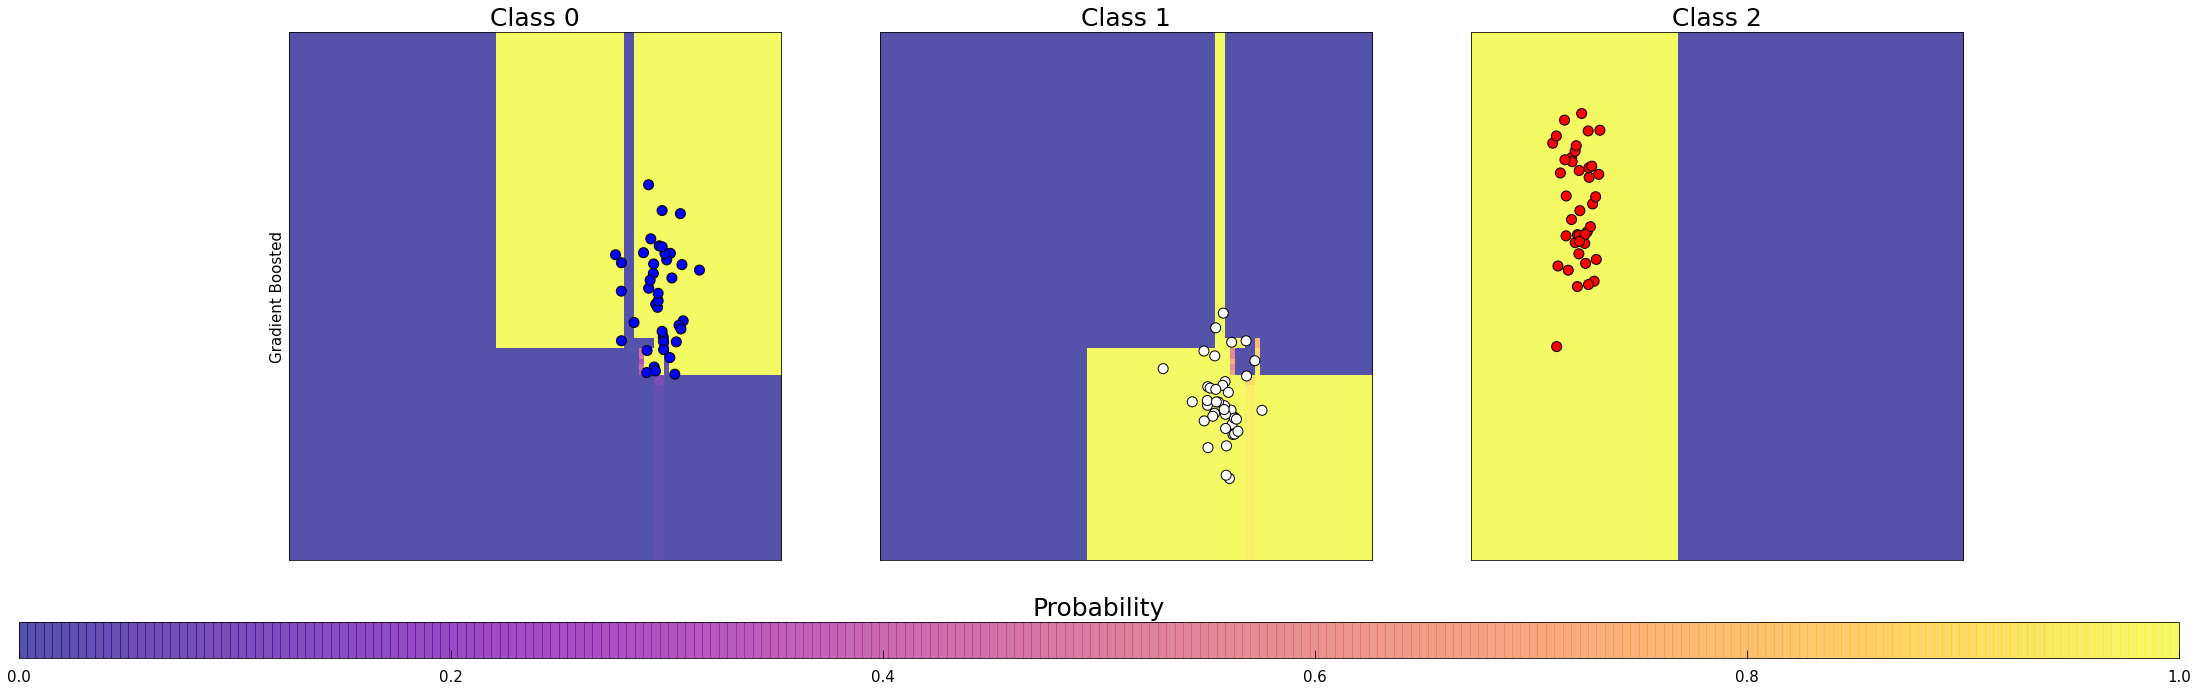

In [196]:
countour_BG(X_3, y_3,1000,0.1,4,2,10,'auto')

Grid best parameter (max. accuracy):  {'learning_rate': 0.060000000000000005, 'max_depth': 2, 'min_samples_leaf': 41, 'min_samples_split': 22, 'n_estimators': 301}
Grid best score (accuracy):  0.9671682626538989
Grid best parameter (max. accuracy) model on test:  0.951048951048951


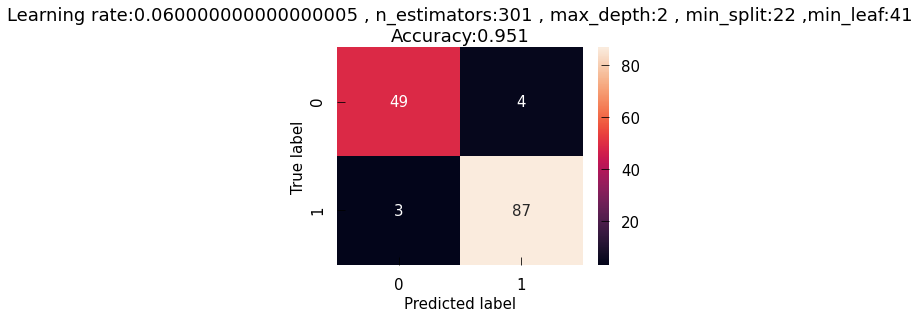

In [197]:
grid_values = {'learning_rate':np.arange(0.01,0.1,0.01),
                'n_estimators':np.arange(1,500,100), 
               'max_depth':np.arange(2,int(len(X_cancer_train)/10),20),
               'min_samples_split':np.arange(2,int(len(X_cancer_train)/10),20),
              'min_samples_leaf':np.arange(1,int(len(X_cancer_train)/10),20)}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_tree_acc = GridSearchCV(GradientBoostingClassifier(), param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_tree_acc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_acc=grid_tree_acc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. accuracy): ', grid_tree_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_tree_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

y_pred_test_c=grid_tree_acc.predict(X_cancer_test)

confusion_mc_c = confusion_matrix(y_cancer_test, y_pred_test_c)
df_cm_c = pd.DataFrame(confusion_mc_c, 
                     index = [i for i in range(0,len(cancer['target_names']))], columns = [i for i in range(0,len(cancer['target_names']))])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm_c, annot=True)
plt.title('Learning rate:'+str(grid_tree_acc.best_params_['learning_rate'])
          +' , n_estimators:'+str(grid_tree_acc.best_params_['n_estimators'])
          +' , max_depth:'+str(grid_tree_acc.best_params_['max_depth'])+' , min_split:'+str(grid_tree_acc.best_params_['min_samples_split'])+
          ' ,min_leaf:'+str(grid_tree_acc.best_params_['min_samples_leaf'])
          +'\nAccuracy:{0:.3f}'.format(accuracy_score(y_cancer_test, 
                                                                       y_pred_test_c)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [198]:
BG = GradientBoostingClassifier(learning_rate=grid_tree_acc.best_params_['learning_rate'],
                              n_estimators=grid_tree_acc.best_params_['n_estimators'],
                             max_depth=grid_tree_acc.best_params_['max_depth'],
                             min_samples_leaf=grid_tree_acc.best_params_['min_samples_leaf'],
                             min_samples_split=grid_tree_acc.best_params_['min_samples_split'])
BG.fit(X_cancer_train, y_cancer_train)
w=BG.feature_importances_#get the weights

sorted_features=sorted([[cancer['feature_names'][i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
soted_feature_df=pd.DataFrame(sorted_features,columns=['feature','abs contribution to the model'])
soted_feature_df

Features sorted per importance in discriminative process


,feature,abs contribution to the model
0,worst perimeter,0.327850
1,worst concave points,0.237644
2,mean concave points,0.199396
3,worst radius,0.126435
4,worst texture,0.036282
5,worst area,0.021740
6,area error,0.018424
7,worst concavity,0.013803
8,mean texture,0.004424
9,worst symmetry,0.003211


# Exercice : go back to the Automobil data set and train a decision tree based algorithm to predict the brand of a car. <a class="anchor" id="exo"></a>

Let's use the automobil dataset (see data exploration : a little bit of data wrangling) to predict what makes a car expensive, mediumly costly or "cheap". Focus on decision tree like models.

You will have to change your numerical price by binning them into categories like : low, medium, high. Give it a number associated to the classes low, medium, high, instead of those names : algo sometimes don't like to work with categorical variables...

You will have to take care of the missing data. If you use models more complex than a simple decision tree (and you should) you will have to change categorical data to numerical one.

What are the main features predictive of a class of prices? What do you think of the reliability of your model??

Hint: the decision_function that we used for the other algo is called predict_proba for decision tree like models

In [199]:
import pandas as pd
df = pd.read_csv('C:\\Users\\sebas\\Desktop\\Rachel cours scikit-learn\\Automobile_data.csv')
df.replace("?", np.nan, inplace = True)

avg_norm_loss = df["normalized-losses"].astype("float").mean(axis=0)
df["normalized-losses"].replace(np.nan, avg_norm_loss, inplace=True)

avg_bore=df['bore'].astype('float').mean(axis=0)
df["bore"].replace(np.nan, avg_bore, inplace=True)

avg_stroke=df['stroke'].astype('float').mean(axis=0)
df["stroke"].replace(np.nan, avg_stroke, inplace=True)

avg_horsepower = df['horsepower'].astype('float').mean(axis=0)
df['horsepower'].replace(np.nan, avg_horsepower, inplace=True)

avg_price = df['price'].astype('float').mean(axis=0)
df['price'].replace(np.nan, avg_price, inplace=True)

avg_peakrpm=df['peak-rpm'].astype('float').mean(axis=0)
df['peak-rpm'].replace(np.nan, avg_peakrpm, inplace=True)

#like replacing by the max used for example
print(df['num-of-doors'].value_counts())
print(df['num-of-doors'].value_counts().idxmax())

df["num-of-doors"].replace(np.nan, "four", inplace=True)

#If your interested in lines rather than columns you can drop lines (index) for which a certaine feature is NAN.
df.dropna(subset=["price"], axis=0, inplace=True)

df.reset_index(drop=True, inplace=True)

df["horsepower"]=df["horsepower"].astype(int, copy=True)

df[["bore", "stroke"]] = df[["bore", "stroke"]].astype("float")
df[["normalized-losses"]] = df[["normalized-losses"]].astype("int")
df[["price"]] = df[["price"]].astype("float")
df[["peak-rpm"]] = df[["peak-rpm"]].astype("float")

bins = np.linspace(min(df["price"]), max(df["price"]), 4)
group_names = ['Low', 'Medium', 'High']

df['price-binned'] = pd.cut(df['price'], bins, labels=group_names, include_lowest=True )
df.drop('price',axis = 1, inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\sebas\\Desktop\\Rachel cours scikit-learn\\Automobile_data.csv'

In [ ]:
df.head()

In [ ]:
X=pd.DataFrame([[df[v][i] for v in df.columns if v!='price-binned'] for i in range(len(df['price-binned']))],index=df.index,columns=[v for v in df.columns if v!='price-binned'])
dico={'Low':0,'Medium':1,'High':2}
y=pd.DataFrame([[dico[df['price-binned'][i]]] for i in range(len(df['price-binned']))],index=df.index,columns=['price-binned'])

In [ ]:
y.head()

In [ ]:
X.dtypes

In [ ]:
keep=[]
for i in range(len(X.columns)):
    if X.dtypes[X.columns[i]]=='object':
        keep.append(X.columns[i])
        dummy_variable_1 = pd.get_dummies(X[X.columns[i]])
        X = pd.concat([X, dummy_variable_1], axis=1)


X.drop(keep,axis = 1, inplace=True)



In [ ]:
X.head()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=0)

In [ ]:
y['price-binned'].value_counts()

#Next cell is correction!So work above!

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#




#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#


#

# One possible correction

In [ ]:
grid_values = {'learning_rate':np.arange(0.01,0.1,0.01),
                'n_estimators':np.arange(1,500,100), 
               'max_depth':np.arange(2,int(len(X_train)),20),
               'min_samples_split':np.arange(2,int(len(X_train)/10),20),
              'min_samples_leaf':np.arange(1,int(len(X_train)/10),20)}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_tree_acc = GridSearchCV(GradientBoostingClassifier(), param_grid = grid_values, scoring='accuracy')#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_tree_acc.fit(X_train, np.array(y_train).ravel())

y_decision_fn_scores_acc=grid_tree_acc.score(X_test,np.array(y_test).ravel())

print('Grid best parameter (max. accuracy): ', grid_tree_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_tree_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

y_pred_test_c=grid_tree_acc.predict(X_test)

confusion_mc_c = confusion_matrix(y_test, y_pred_test_c)
df_cm_c = pd.DataFrame(confusion_mc_c, 
                     index = [i for i in range(0,len(cancer['target_names']))], columns = [i for i in range(0,len(cancer['target_names']))])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm_c, annot=True)
plt.title('Learning rate:'+str(grid_tree_acc.best_params_['learning_rate'])
          +' , n_estimators:'+str(grid_tree_acc.best_params_['n_estimators'])
          +' , max_depth:'+str(grid_tree_acc.best_params_['max_depth'])+' , min_split:'+str(grid_tree_acc.best_params_['min_samples_split'])+
          ' ,min_leaf:'+str(grid_tree_acc.best_params_['min_samples_leaf'])
          +'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                       y_pred_test_c)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
from operator import itemgetter
RFC = GradientBoostingClassifier(learning_rate=grid_tree_acc.best_params_['learning_rate'],
                            n_estimators=grid_tree_acc.best_params_['n_estimators'],
                            max_depth=grid_tree_acc.best_params_['max_depth'],
                            min_samples_split=grid_tree_acc.best_params_['min_samples_split'],
                           min_samples_leaf=grid_tree_acc.best_params_['min_samples_leaf'])
RFC.fit(X_train, np.array(y_train).ravel())
w=RFC.feature_importances_#get the weights

sorted_features=sorted([[X.columns[i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
print(sorted_features)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
n_classes=3


y1 = label_binarize(y_test, classes=np.arange(0,n_classes,1))
#y_score=y_pred_test_c
y_score=RFC.predict_proba(X_test)
#print(y_score)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y1[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y1.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for j in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[j], tpr[j])

        # Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw = 3
# Plot all ROC curves
plt.figure(figsize=(7,7))
plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
        #plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.title('Multi class Receiver operating characteristic curve\nOnevsRest')
plt.legend(loc="lower right")
plt.show()